# Description of Experiment


The most recent version of this notebook is at https://github.com/nickjeffrey/cisis23igpl

This jupyter notebook builds on previous works at https://github.com/nickjeffrey/ensemble_learning

This notebook explores the use of Deep Learning classifiers, which are then fed to an Ensemble Learning model to see if the accuracy can be improved.

This notebook used the following hardware / software resources:  Intel Core i7-10710U (6 core, 12 thread), 64GB RAM, 1TB SSD, Windows 11, Sci-kit Learn, Keras.

# Definitions:

In the context of neural network models, the test loss and test accuracy are performance metrics used to evaluate the model's performance on unseen data, specifically the test set.

Test Loss:

- The test loss measures how well the model is performing on the test set. It represents the average loss (e.g., cross-entropy loss) incurred by the model when making predictions on the test data.
- Lower test loss indicates better performance, as it means that the model's predictions are closer to the actual labels.
However, it's important to consider the scale and nature of the loss function used. For instance, a test loss of 0.1 might be good for one problem but poor for another, depending on the context.


Test Accuracy:

- The test accuracy measures the proportion of correctly classified samples in the test set.
It is calculated by dividing the number of correctly classified samples by the total number of samples in the test set.
- Higher test accuracy indicates better performance, as it means that the model is making more correct predictions.
However, accuracy alone might not provide a complete picture, especially if the classes are imbalanced or if different types of errors have different costs.


In summary, test loss and test accuracy are two important metrics used to assess the performance of a SimpleRNN model on unseen data. Lower test loss and higher test accuracy generally indicate better performance, but it's essential to consider other factors such as the nature of the problem, class imbalance, and potential costs associated with different types of errors.

# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing   import LabelEncoder
from collections import Counter

# Miscellaneous packages
import time                                           #for calculating elapsed time for training tasks
import os                                             #for checking if file exists
import socket                                         #for getting FQDN of local machine
import math                                           #square root function
import sys


# Packages from scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV       #for hyperparameter optimization
from sklearn.model_selection import cross_val_score    #for cross fold validation
from sklearn.metrics         import make_scorer        #used by GridSearchCV
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.naive_bayes     import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neural_network  import MLPClassifier      #neural network classifier
from sklearn.ensemble        import BaggingClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier   #Packages for Ensemble Learning

# packages for balancing classes
from imblearn.under_sampling import RandomUnderSampler  #may need to install with: conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling  import SMOTE               #may need to install with: conda install -c conda-forge imbalanced-learn

# Deep Learning classifiers

import tensorflow as tf
from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import binary_crossentropy
from tensorflow.keras.metrics    import Accuracy






In [2]:
# # KerasClassifier was moved to scikeras in version 2.13.0, so you will need to install the package, but this will break other things!

# import importlib.util

# # Check if scikeras is installed
# if importlib.util.find_spec("scikeras") is None:
#   print("scikeras is not installed, attempting installation now.")
#   !pip install scikeras
# else:
#   print("scikeras is already installed.")


# # after confirming the scikeras package was installed, you can now import KerasClassifier,
# #  which is used for SimpleRNN hyperparameter optimization
# from scikeras.wrappers import KerasClassifier, KerasRegressor

In [3]:
# WARNING: do not use tensorflow.keras.wrappers.scikit_learn
# DEPRECATED. Use [Sci-Keras](https://github.com/adriangb/scikeras) instead.
# See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


# import pkg_resources

# # Get a list of installed packages and their versions
# installed_packages = {package.key: package.version for package in pkg_resources.working_set}

# # Uninstall TensorFlow if installed version is greater than 2.12.0
# if 'tensorflow' in installed_packages and installed_packages['tensorflow'] > '2.12.0':
#   pip.main(['uninstall', '-y', 'tensorflow'])
#   print("TensorFlow uninstalled successfully")
# else:
#   print("Did not find a version of TensorFlow greater than 2.12.0")



# # Check if TensorFlow is installed and its version is greater than 2.12.0
# if 'tensorflow' in installed_packages and installed_packages['tensorflow'] == '2.12.0':
#   print("TensorFlow 2.12.0 is already installed")
# else:
#   print("Installing TensorFlow 2.12.0")
#   pip.main(['install', 'tensorflow==2.12.0'])



# # At this point, tensorflow 2.12.0 is installed, so import the package we want
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# # Print the installed version of KerasClassifier
# #print("Installed version of KerasClassifier:", KerasClassifier.__version__)
# KerasClassifier

# #!pip uninstall -y tensorflow
# #!pip install tensorflow==2.12.0

# Define functions

In [4]:
# function to show missing values in dataset

def get_type_missing(df):
    df_types = pd.DataFrame()
    df_types['data_type'] = df.dtypes
    df_types['missing_values'] = df.isnull().sum()
    return df_types.sort_values(by='missing_values', ascending=False)

In [5]:
# function to create a confusion matrix

def visualize_confusion_matrix(y_test, y_pred):
    #
    ## Calculate accuracy
    #accuracy = accuracy_score(y_test, y_pred)
    #print("Accuracy:", accuracy)
    #
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    #
    # visualize confusion matrix with more detailed labels
    # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    #
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(3.5, 2.0))  #default figsize is 6.4" wide x 4.8" tall, shrink to 3.5" wide 2.0" tall
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # use the .ravel function to pull out TN,TP,FN,TP
    # https://analytics4all.org/2020/05/07/python-confusion-matrix/
    TN, FP, FN, TP = cm.ravel()

    # calculate different metrics
    Accuracy = (( TP + TN) / ( TP + TN + FP + FN))
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    GeometricMean = math.sqrt(Sensitivity * Specificity)

    # Precision is the ratio of true positive predictions to the total number of positive predictions made by the model
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    Precision = precision_score(y_test, y_pred, average='weighted')

    # Recall is the ratio of true positive predictions to the total number of actual positive instances in the data.
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    Recall = recall_score(y_test, y_pred, average='weighted')

    # F1-score is a metric that considers both precision and recall, providing a balance between the two.
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    F1 = f1_score(y_test, y_pred, average='weighted')

    # add details below graph to help interpret results
    print('\n\n')
    print('Confusion matrix\n\n', cm)
    print('\nTrue Negatives  (TN) = ', TN)
    print('False Positives (FP) = ', FP)
    print('False Negatives (FN) = ', FN)
    print('True Positives  (TP) = ', TP)
    print ('\n')
    print ("Accuracy:       ", Accuracy)
    print ("Sensitivity:    ", Sensitivity)
    print ("Specificity:    ", Specificity)
    print ("Geometric Mean: ", GeometricMean)
    print ('\n')
    print ("Precision:       ", Precision)
    print ("Recall:          ", Recall)
    print ("f1-score:        ", F1)

    print('\n------------------------------------------------\n')
    # We want TN and TP to be approximately equal, because this indicates the dataset is well balanced.
    # If TN and TP are very different, it indicates imbalanced data, which can lead to low accuracy due to overfitting
    #if (TN/TP*100 < 40 or TN/TP*100 > 60):   #we want TN and TP to be approximately 50%, if the values are below 40% or over 60%, generate a warning
    #    print("WARNING: the confusion matrix shows that TN and TP are very imbalanced, may lead to low accuracy!")
    #
    return cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1





In [6]:
# function to report on model accuracy (TP, FP, FN, FP), precision, recall, f1-score
# this function does not provide anything additional to the results from the previous function

def model_classification_report(cm, y_test, y_pred):
    report = classification_report(y_test, y_pred, digits=4)
    print('\n')
    print("Classification Report: \n", report)
    print('\n\n\n')



In [7]:
# function to show elapsed time for running notebook

# start a timer so we can calculate the total runtime of this notebook
notebook_start_time = time.time()  #seconds since epoch

def show_elapsed_time():
    #
    # Get the current time as a struct_time object
    current_time_struct = time.localtime()

    # Format the struct_time as a string (yyyy-mm-dd HH:MM:SS format)
    current_time_str = time.strftime("%Y-%m-%d %H:%M:%S", current_time_struct)

    # Display the current time in HH:MM:SS format
    print("Current Time:", current_time_str)

    # show a running total of elapsed time for the entire notebook
    notebook_end_time = time.time()  #seconds since epoch
    print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

show_elapsed_time()

Current Time: 2024-05-13 17:19:45
The entire notebook runtime so far is 0 minutes


In [8]:
# create a function to plot Training Loss and Validation Loss for Neural Network classifiers

def plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count):
    if len(train_loss_history_unoptimized) == 0 or len(train_loss_history_optimized) == 0 or len(val_loss_history_unoptimized) == 0 or len(val_loss_history_optimized) == 0:
        print("ERROR: cannot find loss history, using all zeros")
        raise ValueError ("ERROR: Cannot find loss history, please investigate!")
    #
    # sanity check to confirm the same number of epochs were used before and after hyperparameter optimization
    if len(train_loss_history_unoptimized) != len(train_loss_history_optimized) or len(val_loss_history_unoptimized) != len(val_loss_history_optimized):
        raise ValueError ("ERROR: different number of epochs used before and after hyperparameter optimziation")

    # Create two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Create two subplots side by side

    # Plot for loss before optimization
    axs[0].plot(train_loss_history_unoptimized, label='Train Loss before optimizing', color='blue', linestyle='--')
    axs[0].plot(val_loss_history_unoptimized, label='Validation Loss before optimizing', color='red', linestyle='--')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train / Val Loss before optimization')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for loss after optimization
    axs[1].plot(train_loss_history_optimized, label='Train Loss after optimizing', color='blue', linestyle='-')
    axs[1].plot(val_loss_history_optimized, label='Validation Loss after optimizing', color='red', linestyle='-')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Train / Val Loss after optimization')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    # the lines should be very close to converging by the final epoch
    # since list indexes start at 0 instead of 1, use epoch_count-1 as the index for the last value
    # maximum acceptable divergence
    divergence_threshold = 0.01
    divergence_unoptimized = abs(train_loss_history_unoptimized[epoch_count-1] - val_loss_history_unoptimized[epoch_count-1])
    divergence_optimized   = abs(train_loss_history_optimized[epoch_count-1]   - val_loss_history_optimized[epoch_count-1])
    if divergence_optimized > divergence_threshold:
        print(f"WARNING, after optimization, loss divergence is {divergence_optimized}, which greater than threshold of {divergence_threshold}, please continue tuning this model.")
    else:
        print(f"After optimization, loss divergence is {divergence_optimized:.3f}, which is <= threshold of {divergence_threshold}, this model has acceptable loss.")

# Example usage:
#epoch_count = 5
#train_loss_history_unoptimized = [1, 2, 3, 4, 5]
#train_loss_history_optimized = [1, 2, 3, 4, 5]
#val_loss_history_unoptimized = [1, 2, 3, 4, 5]
#val_loss_history_optimized = [1, 2, 3, 4, 5]
#plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)



In [9]:
# create a function to plot Training Accuracy and Validation Accuracy for Neural Network classifiers

def plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count):
    # sanity check to confirm the required values have already been collected
    if len(train_accuracy_history_unoptimized) == 0 or len(train_accuracy_history_optimized) == 0 or len(val_accuracy_history_unoptimized) == 0 or len(val_accuracy_history_optimized) == 0:
        print("ERROR: cannot find accuracy history")
        raise ValueError ("ERROR: Cannot find accuracy history, please investigate!")
    # sanity check to confirm the same number of epochs were used before and after hyperparameter optimization
    if len(train_accuracy_history_unoptimized) != len(train_accuracy_history_optimized) or len(val_accuracy_history_unoptimized) != len(val_accuracy_history_optimized):
        raise ValueError ("ERROR: different number of epochs used before and after hyperparameter optimziation")


    # Create two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Create two subplots side by side

    # Plot for accuracy before optimization
    axs[0].plot(train_accuracy_history_unoptimized, label='Train Accuracy before optimizing',      color='blue', linestyle='--')
    axs[0].plot(val_accuracy_history_unoptimized,   label='Validation Accuracy before optimizing', color='red',  linestyle='--')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Train / Val Accuracy before optimization')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for accuracy after optimization
    axs[1].plot(train_accuracy_history_optimized, label='Train Accuracy after optimizing',      color='blue', linestyle='-')
    axs[1].plot(val_accuracy_history_optimized,   label='Validation Accuracy after optimizing', color='red',  linestyle='-')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train / Val Accuracy after optimization')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    # the lines should be very close to converging by the final epoch
    # since list indexes start at 0 instead of 1, use epoch_count-1 as the index for the last value
    # maximum acceptable divergence
    divergence_threshold = 0.01
    divergence_unoptimized = abs(train_accuracy_history_unoptimized[epoch_count-1] - val_accuracy_history_unoptimized[epoch_count-1])
    divergence_optimized   = abs(train_accuracy_history_optimized[epoch_count-1]   - val_accuracy_history_optimized[epoch_count-1])
    if divergence_optimized > divergence_threshold:
        print(f"WARNING, after optimization, accuracy divergence is {divergence_optimized}, which greater than threshold of {divergence_threshold}, please continue tuning this model.")
    else:
        print(f"After optimization, accuracy divergence is {divergence_optimized:.3f}, which is <= threshold of {divergence_threshold}, this model has acceptable accuracy.")

# Example usage:
#epoch_count = 10
#train_accuracy_history_unoptimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.5]
#train_accuracy_history_optimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.4]
#val_accuracy_history_unoptimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.5]
#val_accuracy_history_optimized = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0.4]
#plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)



# Initialize variables


In [10]:
# initialize variables to avoid undef errors

accuracy_lr_unoptimized               = 0
accuracy_lr_optimized                 = 0
accuracy_nb_unoptimized               = 0
accuracy_nb_optimized                 = 0
accuracy_knn_unoptimized              = 0
accuracy_knn_optimized                = 0
accuracy_svm_unoptimized              = 0
accuracy_svm_optimized                = 0
accuracy_dt_unoptimized               = 0
accuracy_dt_optimized                 = 0
accuracy_rf_unoptimized               = 0
accuracy_rf_optimized                 = 0
accuracy_gb_unoptimized               = 0
accuracy_gb_optimized                 = 0
accuracy_mlp_unoptimized              = 0
accuracy_mlp_optimized                = 0
accuracy_fnn_unoptimized              = 0
accuracy_fnn_optimized                = 0
accuracy_sequential_unoptimized       = 0
accuracy_sequential_optimized         = 0
accuracy_cnn_unoptimized              = 0
accuracy_cnn_optimized                = 0
accuracy_rnn_unoptimized              = 0
accuracy_rnn_optimized                = 0
accuracy_lstm_unoptimized             = 0
accuracy_lstm_optimized               = 0
accuracy_gru_unoptimized              = 0
accuracy_gru_optimized                = 0



test_accuracy_sequential_unoptimized       = 0
test_loss_sequential_unoptimized           = 0
train_accuracy_sequential_unoptimized      = 0
train_loss_sequential_unoptimized          = 0
test_accuracy_sequential_optimized         = 0
test_loss_sequential_optimized             = 0
train_accuracy_sequential_optimized        = 0
train_loss_sequential_optimized            = 0
val_accuracy_sequential_unoptimized        = 0
val_loss_sequential_unoptimized            = 0
val_accuracy_sequential_optimized          = 0
val_loss_sequential_optimized              = 0

test_accuracy_lstm_unoptimized             = 0
test_loss_lstm_unoptimized                 = 0
train_accuracy_lstm_unoptimized            = 0
train_loss_lstm_unoptimized                = 0
test_accuracy_lstm_optimized               = 0
test_loss_lstm_optimized                   = 0
train_accuracy_lstm_optimized              = 0
train_loss_lstm_optimized                  = 0
val_accuracy_lstm_unoptimized              = 0
val_loss_lstm_unoptimized                  = 0
val_accuracy_lstm_optimized                = 0
val_loss_lstm_optimized                    = 0

test_accuracy_simplernn_unoptimized        = 0
test_loss_simplernn_unoptimized            = 0
train_accuracy_simplernn_unoptimized       = 0
train_loss_simplernn_unoptimized           = 0
test_accuracy_simplernn_optimized          = 0
test_loss_simplernn_optimized              = 0
train_accuracy_simplernn_optimized         = 0
train_loss_simplernn_optimized             = 0
val_accuracy_simplernn_unoptimized         = 0
val_loss_simplernn_unoptimized             = 0
val_accuracy_simplernn_optimized           = 0
val_loss_simplernn_optimized               = 0

test_accuracy_simplernn_lstm_unoptimized   = 0
test_loss_simplernn_lstm_unoptimized       = 0
train_accuracy_simplernn_lstm_unoptimized  = 0
train_loss_simplernn_lstm_unoptimized      = 0
test_accuracy_simplernn_lstm_optimized     = 0
test_loss_simplernn_lstm_optimized         = 0
train_accuracy_simplernn_lstm_optimized    = 0
train_loss_simplernn_lstm_optimized        = 0
val_accuracy_simplernn_lstm_unoptimized    = 0
val_loss_simplernn_lstm_unoptimized        = 0
val_accuracy_simplernn_lstm_optimized      = 0
val_loss_simplernn_lstm_optimized          = 0


test_accuracy_gru_unoptimized              = 0
test_loss_gru_unoptimized                  = 0
train_accuracy_gru_unoptimized             = 0
train_loss_gru_unoptimized                 = 0
test_accuracy_gru_optimized                = 0
test_loss_gru_optimized                    = 0
train_accuracy_gru_optimized               = 0
train_loss_gru_optimized                   = 0
val_accuracy_gru_unoptimized               = 0
val_loss_gru_unoptimized                   = 0
val_accuracy_gru_optimized                 = 0
val_loss_gru_optimized                     = 0

best_params_mlp                       = ""
best_params_sequential                = ""
best_params_lstm                      = ""
best_params_simplernn                 = ""
best_params_simplernn_lstm            = ""
best_params_gru                       = ""


accuracy_ensemble_voting              = 0
accuracy_ensemble_stacking            = 0
accuracy_ensemble_boosting            = 0
accuracy_ensemble_bagging             = 0


cv_count                              = 10  #number of cross-validation folds
epoch_count                           = 25  #number of epochs for neural network classifiers
epoch_verbosity                       = 0   #For NN classifiers with epochs. 0=silent training, 1 will show progress bars, 2 will provide a concise summary per epoch.
verbosity                             = 0   # for MLP, LR, DT classifiers.

train_loss_history_unoptimized = [0] * epoch_count
train_loss_history_optimized   = [0] * epoch_count
val_loss_history_unoptimized   = [0] * epoch_count
val_loss_history_optimized     = [0] * epoch_count


In [11]:
# # Load pickled datasets

# # Determine the best location to obtain the source *.pkl file

# # define *.pkl source file
# filename = 'Edge-IIoTset2023_scaled_data_tuple.pkl'
# LAN_location = 'http://datasets.nyx.local:80/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'  #high speed local copy on LAN
# WAN_location = 'http://datasets.nyx.ca:8081/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'   #accessible to entire internet

# #filename = 'CIC_IOT_Dataset2023_scaled_data_tuple.pkl'
# #LAN_location = 'http://datasets.nyx.local:80/datasets/CIC_IOT_Dataset2023/csv'  #high speed local copy on LAN
# #WAN_location = 'http://datasets.nyx.ca:8081/datasets/CIC_IOT_Dataset2023/csv'   #accessible to entire internet

# # Get the FQDN of the local machine
# fqdn = socket.getfqdn()
# ipv4_address = socket.gethostbyname(socket.gethostname())
# print(f"Fully Qualified Domain Name (FQDN):{fqdn}, IPv4 address:{ipv4_address}")
# if ( "nyx.local" in fqdn ):
#     # If inside the LAN, grab the local copy of the dataset
#     print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{LAN_location}/{filename}")
#     dataset = f"{LAN_location}/{filename}"
# else:
#     # If not inside the LAN, grab the dataset from an internet-accessible URL
#     print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{WAN_location}/{filename}")
#     dataset = f"{WAN_location}/{filename}"




# # Load pickle file from dataset that has already been labeled, scaled, randomly undersampled, and split into train/test/val

# if not os.path.exists(filename):
#   print(f"Retrieving pickle file", dataset)
#   #!wget {dataset}          #wget typically exists on Linux but not Windows
#   !curl -O {dataset}        #curl typically exists on both Linux and Windows
# else:
#   print(f"Pickle file {filename} already exists")




# # Open the pickle file

# # uncomment the filename you want to load
# pickle_file = "Edge-IIoTset2023_scaled_data_tuple.pkl"
# #pickle_file = "CIC_IOT_Dataset2023_scaled_data_tuple.pkl"

# # Load the tuple using pickle
# with open(pickle_file, 'rb') as f:
#     #data_tuple = pickle.load(f)               #syntax for pandas <  version 2.0
#     data_tuple = pd.read_pickle(pickle_file)   #syntax for pandas >= version 2.0

# # split the pickle file into the lists from the source dataset
# X_train, X_test, X_val, y_train, y_test, y_val = data_tuple



# Load raw dataset

In [12]:
# define CSV source file

filename = 'DNN-EdgeIIoT-dataset.csv'
LAN_location = 'http://datasets.nyx.local:80/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'  #high speed local copy on LAN
WAN_location = 'http://datasets.nyx.ca:8081/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'   #accessible to entire internet



# Get the FQDN of the local machine
fqdn = socket.getfqdn()
ipv4_address = socket.gethostbyname(socket.gethostname())
print(f"Fully Qualified Domain Name (FQDN):{fqdn}, IPv4 address:{ipv4_address}")
if ( "nyx.local" in fqdn ):
    # If inside the LAN, grab the local copy of the dataset
    print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{LAN_location}/{filename}")
    dataset = f"{LAN_location}/{filename}"
else:
    # If not inside the LAN, grab the dataset from an internet-accessible URL
    print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{WAN_location}/{filename}")
    dataset = f"{WAN_location}/{filename}"




Fully Qualified Domain Name (FQDN):08387618b6e2, IPv4 address:172.28.0.12
Detected Fully Qualified Domain Name of 08387618b6e2, dataset source is:
http://datasets.nyx.ca:8081/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL/DNN-EdgeIIoT-dataset.csv


In [13]:
# check to see if the dataset has already been retrieved from the remote web server

if not os.path.exists(filename):
  print(f"Retrieving dataset", dataset)
  #!wget {dataset}          #wget typically exists on Linux but not Windows
  !curl -O {dataset}        #curl typically exists on both Linux and Windows
else:
  print(f"File {filename} already exists")


Retrieving dataset http://datasets.nyx.ca:8081/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL/DNN-EdgeIIoT-dataset.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1161M  100 1161M    0     0  5852k      0  0:03:23  0:03:23 --:--:-- 4305k


In [14]:
# Confirm the source datafile exists locally, just in case the previous cell failed to load the CSV file
if not os.path.exists(filename):
    raise FileNotFoundError(f"The file '{file_path}' does not exist.")
else:
    print(f"Confirmed existence of filename {filename}")

Confirmed existence of filename DNN-EdgeIIoT-dataset.csv


In [15]:
# Load the CSV file
print(f"Loading dataset from {filename}")
df = pd.read_csv(filename)

Loading dataset from DNN-EdgeIIoT-dataset.csv


<ipython-input-15-974a9d5cb368>:3: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [16]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (2219201, 63)


In [17]:
print(f"Dropping rows from the dataset during debugging to speed up this notebook - turn this off when finished debugging!")

# cut dataset in half if > 2 million rows
if ( len(df) > 2000000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# cut dataset in half if > 1 million rows
if ( len(df) > 1000000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# # cut dataset in half if > 0.5 million rows
# if ( len(df) > 500000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# # cut dataset in half if > 0.5 million rows
# if ( len(df) > 500000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# # cut dataset in half if > 250,000 rows
# if ( len(df) > 250000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


# # cut dataset in half if > 100,000 rows
# if ( len(df) > 100000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


#  # cut dataset in half if > 50,000 rows
# if ( len(df) > 50000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


# # cut dataset in half if > 25,000 rows
# if ( len(df) > 25000):
#     print(f"Original size of dataset is", len(df), " rows")
#     df.drop(df.index[::2], inplace=True)
#     print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


Dropping rows from the dataset during debugging to speed up this notebook - turn this off when finished debugging!
Original size of dataset is 2219201  rows
Dataset size after dropping all the even-numbered rows is 1109600  rows
Original size of dataset is 1109600  rows
Dataset size after dropping all the even-numbered rows is 554800  rows


In [18]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (554800, 63)


In [19]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-13 17:23:44
The entire notebook runtime so far is 4 minutes


# Exploratory Data Analysis (EDA)

In [20]:
# take a quick look at the data
df.head()

frame.time    ip.src_host    ip.dst_host  \
3    2021 11:44:10.162641000   192.168.0.128  192.168.0.101   
7    2021 11:44:10.167072000   192.168.0.128  192.168.0.101   
11   2021 11:44:10.172672000   192.168.0.128  192.168.0.101   
15   2021 11:44:10.173605000   192.168.0.101  192.168.0.128   
19   2021 11:44:10.176556000   192.168.0.128  192.168.0.101   

   arp.dst.proto_ipv4  arp.opcode  arp.hw.size arp.src.proto_ipv4  \
3                   0         0.0          0.0                  0   
7                   0         0.0          0.0                  0   
11                  0         0.0          0.0                  0   
15                  0         0.0          0.0                  0   
19                  0         0.0          0.0                  0   

    icmp.checksum  icmp.seq_le  icmp.transmit_timestamp  ...  mqtt.proto_len  \
3             0.0          0.0                      0.0  ...             0.0   
7             0.0          0.0                      0.0  ...             0.0   
11            0.0          0.0                      0.0  ...             0.0   
15            0.0          0.0                      0.0  ...             0.0   
19            0.0          0.0                      0.0  ...             0.0   

   mqtt.protoname  mqtt.topic mqtt.topic_len mqtt.ver mbtcp.len  \
3               0           0            0.0      0.0       0.0   
7               0           0            0.0      0.0       0.0   
11              0           0            0.0      0.0       0.0   
15              0           0            0.0      0.0       0.0   
19              0           0            0.0      0.0       0.0   

   mbtcp.trans_id mbtcp.unit_id  Attack_label  Attack_type  
3             0.0           0.0             0       Normal  
7             0.0           0.0             0       Normal  
11            0.0           0.0             0       Normal  
15            0.0           0.0             0       Normal  
19            0.0           0.0             0       Normal  

[5 rows x 63 columns]

In [21]:
# Display all the data rather than just a portion
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [22]:
# check for any missing values in dataset
df.isna().sum()

frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64

In [23]:
# check for any missing datatypes
get_type_missing(df)

data_type  missing_values
frame.time               object               0
mqtt.conflags           float64               0
tcp.srcport              object               0
udp.port                float64               0
udp.stream              float64               0
...                         ...             ...
tcp.connection.synack   float64               0
tcp.dstport             float64               0
tcp.flags               float64               0
tcp.flags.ack           float64               0
Attack_type              object               0

[63 rows x 2 columns]

In [24]:
df.describe()

arp.opcode    arp.hw.size  icmp.checksum    icmp.seq_le  \
count  554800.000000  554800.000000  554800.000000  554800.000000   
mean        0.003282       0.015725    1730.015530    1891.844324   
std         0.067783       0.306758    8524.667822    8866.570547   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         2.000000       6.000000   65531.000000   65534.000000   

       icmp.transmit_timestamp  icmp.unused  http.content_length  \
count             5.548000e+05     554800.0        554800.000000   
mean              2.772060e+03          0.0             4.628239   
std               4.616898e+05          0.0            53.717688   
min               0.000000e+00          0.0             0.000000   
25%               0.000000e+00          0.0             0.000000   
50%               0.000000e+00          0.0             0.000000   
75%               0.000000e+00          0.0             0.000000   
max               7.723033e+07          0.0          1465.000000   

       http.response  http.tls_port       tcp.ack  ...       mqtt.len  \
count  554800.000000       554800.0  5.548000e+05  ...  554800.000000   
mean        0.014369            0.0  2.233053e+07  ...       1.966008   
std         0.119007            0.0  1.636440e+08  ...       7.592384   
min         0.000000            0.0  0.000000e+00  ...       0.000000   
25%         0.000000            0.0  1.000000e+00  ...       0.000000   
50%         0.000000            0.0  6.000000e+00  ...       0.000000   
75%         0.000000            0.0  5.900000e+01  ...       0.000000   
max         1.000000            0.0  3.949529e+09  ...      39.000000   

       mqtt.msg_decoded_as   mqtt.msgtype  mqtt.proto_len  mqtt.topic_len  \
count             554800.0  554800.000000   554800.000000   554800.000000   
mean                   0.0       0.743585        0.152949        0.881312   
std                    0.0       2.692221        0.767074        4.513847   
min                    0.0       0.000000        0.000000        0.000000   
25%                    0.0       0.000000        0.000000        0.000000   
50%                    0.0       0.000000        0.000000        0.000000   
75%                    0.0       0.000000        0.000000        0.000000   
max                    0.0      14.000000        4.000000       24.000000   

            mqtt.ver      mbtcp.len  mbtcp.trans_id  mbtcp.unit_id  \
count  554800.000000  554800.000000   554800.000000  554800.000000   
mean        0.152949       0.001197        0.004475       0.000092   
std         0.767074       0.161057        0.653589       0.012807   
min         0.000000       0.000000        0.000000       0.000000   
25%         0.000000       0.000000        0.000000       0.000000   
50%         0.000000       0.000000        0.000000       0.000000   
75%         0.000000       0.000000        0.000000       0.000000   
max         4.000000      27.000000      143.000000       4.000000   

        Attack_label  
count  554800.000000  
mean        0.271972  
std         0.444976  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000  

[8 rows x 43 columns]

In [25]:
# look at all the datatypes of that are objects, in case any can be converted to integers
df.describe(include='object')

frame.time    ip.src_host    ip.dst_host arp.dst.proto_ipv4  \
count          554800         554800         554800             554800   
unique         551623          34159          13256                  9   
top     192.168.0.128  192.168.0.128  192.168.0.128                  0   
freq             2874         241145         239033             421352   

       arp.src.proto_ipv4  http.file_data  http.request.uri.query  \
count              554800        554800.0                554800.0   
unique                  8           592.0                  2021.0   
top                     0             0.0                     0.0   
freq               397930        497456.0                522032.0   

        http.request.method  http.referer  http.request.full_uri  \
count              554800.0      554800.0               554800.0   
unique                  7.0           5.0                 4914.0   
top                     0.0           0.0                    0.0   
freq               481072.0      526128.0               481072.0   

        http.request.version tcp.options tcp.payload  tcp.srcport  \
count               554800.0      554800      554800     554800.0   
unique                   8.0       67886       70451      43152.0   
top                      0.0           0           0       1883.0   
freq                481072.0      363908      325219     165294.0   

        dns.qry.name.len mqtt.conack.flags mqtt.msg mqtt.protoname mqtt.topic  \
count             554800            554800   554800         554800     554800   
unique                11                 9      134              4          4   
top                    0                 0        0              0          0   
freq              493360            383088   383537         382696     383537   

       Attack_type  
count       554800  
unique          15  
top         Normal  
freq        403910

In [26]:
# look at the values in all of the features

feature_names = df.columns.tolist()

for feature_name in feature_names:
    if feature_name in df.columns:
        print('\n')
        print(f"------------------")
        print(f"{feature_name}")
        print(f"------------------")
        print(df[feature_name].value_counts())




------------------
frame.time
------------------
frame.time
192.168.0.128                2874
0.0                           219
6.0                            85
 2021 19:39:49.622235000        2
141.134.131.255                 2
                             ... 
 2021 20:06:29.765367000        1
 2021 20:06:29.761868000        1
 2021 20:06:29.758198000        1
 2021 20:06:29.754963000        1
 2021 23:24:32.820831000        1
Name: count, Length: 551623, dtype: int64


------------------
ip.src_host
------------------
ip.src_host
192.168.0.128      241145
192.168.0.101      166822
0                   71411
192.168.0.170       40779
0.0.0.0               258
                    ...  
106.213.24.116          1
125.117.54.227          1
242.100.141.108         1
51.101.81.106           1
18.132.75.125           1
Name: count, Length: 34159, dtype: int64


------------------
ip.dst_host
------------------
ip.dst_host
192.168.0.128      239033
192.168.0.101      166307
0              

In [27]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (554800, 63)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554800 entries, 3 to 2219199
Data columns (total 63 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   frame.time                 554800 non-null  object 
 1   ip.src_host                554800 non-null  object 
 2   ip.dst_host                554800 non-null  object 
 3   arp.dst.proto_ipv4         554800 non-null  object 
 4   arp.opcode                 554800 non-null  float64
 5   arp.hw.size                554800 non-null  float64
 6   arp.src.proto_ipv4         554800 non-null  object 
 7   icmp.checksum              554800 non-null  float64
 8   icmp.seq_le                554800 non-null  float64
 9   icmp.transmit_timestamp    554800 non-null  float64
 10  icmp.unused                554800 non-null  float64
 11  http.file_data             554800 non-null  object 
 12  http.content_length        554800 non-null  float64
 13  http.request.uri.query     5

# Dataset preprocessing

## Fix up feature names

In [29]:
# look at the column names
df.columns

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [30]:
print(df['frame.time'].value_counts().head())

print("\nNull Values:")
print(df['frame.time'].isna().sum())

frame.time
192.168.0.128                2874
0.0                           219
6.0                            85
 2021 19:39:49.622235000        2
141.134.131.255                 2
Name: count, dtype: int64

Null Values:
0


In [31]:
# converting to datetime
def convert_to_datetime(value):
    try:
         return pd.to_datetime(value)
    except:
        return np.nan

# skip the time-consuming conversion because we drop this feature later
#df['frame.time'] = df['frame.time'].apply(convert_to_datetime)

In [32]:
# Validating IP address

print(df['ip.src_host'].value_counts().head())
print('_________________________________________________________')
print(df['ip.dst_host'].value_counts().head())
print('_________________________________________________________')
print(df['arp.src.proto_ipv4'].value_counts().head())
print('_________________________________________________________')
print(df['arp.dst.proto_ipv4'].value_counts().head())

ip.src_host
192.168.0.128    241145
192.168.0.101    166822
0                 71411
192.168.0.170     40779
0.0.0.0             258
Name: count, dtype: int64
_________________________________________________________
ip.dst_host
192.168.0.128    239033
192.168.0.101    166307
0                 94614
192.168.0.170     36309
0                  4096
Name: count, dtype: int64
_________________________________________________________
arp.src.proto_ipv4
0                397930
0                153392
0.0                2024
192.168.0.1         777
192.168.0.128       374
Name: count, dtype: int64
_________________________________________________________
arp.dst.proto_ipv4
0                421352
0                128816
192.168.0.128      3261
192.168.0.147       551
0.0                 304
Name: count, dtype: int64


In [33]:
# just for fun explore these values in the http.file_data column
#df[df['Attack_label'] == 1]['http.file_data'].value_counts()


In [34]:
df['mqtt.topic'].value_counts()

mqtt.topic
0                           383537
0.0                         149296
Temperature_and_Humidity     20373
0.0                           1594
Name: count, dtype: int64

In [35]:
df['mqtt.protoname'].value_counts()

mqtt.protoname
0       382696
0.0     149296
MQTT     21214
0.0       1594
Name: count, dtype: int64

In [36]:
df['dns.qry.name.len'].value_counts()

dns.qry.name.len
0                         493360
0                          59392
0.0                         1537
0.debian.pool.ntp.org        115
2.debian.pool.ntp.org        114
3.debian.pool.ntp.org        109
1.debian.pool.ntp.org        105
1.0                           57
raspberrypi.local              8
_googlecast._tcp.local         2
null-null.local                1
Name: count, dtype: int64

In [37]:
df['http.request.method'].value_counts()

http.request.method
0.0         481072
0            48176
0.0          17454
GET           7676
POST           326
TRACE           95
PROPFIND         1
Name: count, dtype: int64

In [38]:
# how many 0 (normal) and 1 (attack) values do we have?
df['Attack_label'].value_counts()

Attack_label
0    403910
1    150890
Name: count, dtype: int64

# Visualization of raw dataset

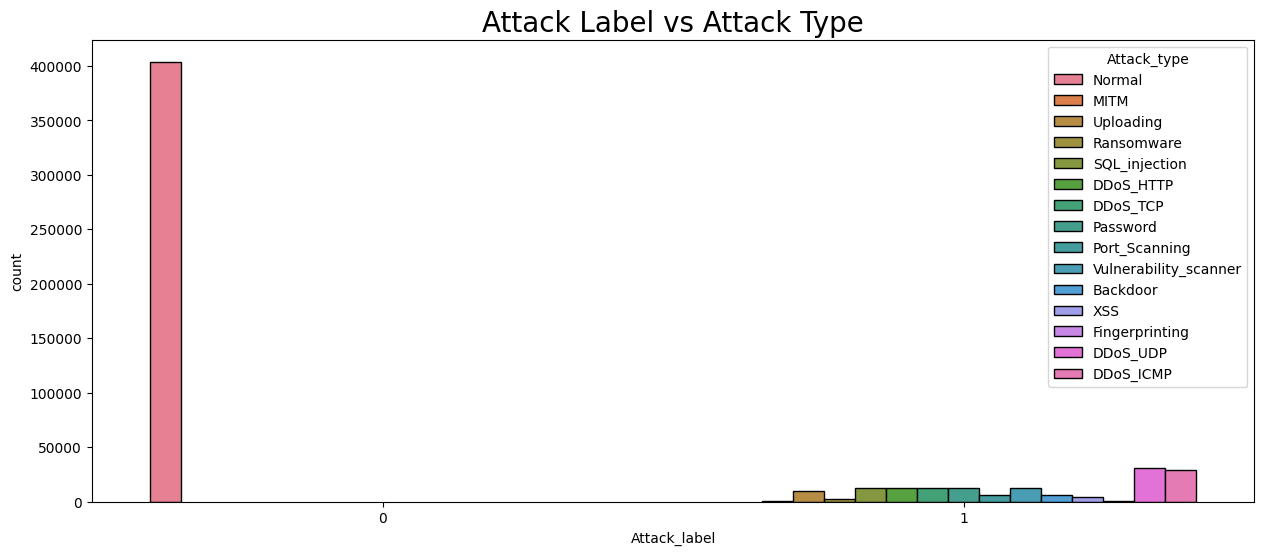

In [39]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Attack_label', hue='Attack_type', edgecolor='black', linewidth=1)
plt.title('Attack Label vs Attack Type', fontsize=20)
plt.show()

In [40]:
import plotly.express as px

fig = px.pie(df, names='Attack_label', title='Distribution of Attack Labels')
fig.show()


In [41]:
fig = px.pie(df, names='Attack_type', title='Distribution of Attack Type')
fig.show()


- class imbalance issue - this can cause the machine learning model to result in biased results

# Drop features
Now using our domain knowledge we will only select useful features from our dataset and drop the rest

In [42]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (554800, 63)


In [43]:
# Identifying columns that are entirely NaN (empty) or have all zero values
empty_or_zero_columns = df.columns[(df.isnull().all())
| (df == 0).all()   | (df == 1).all() | (df == 1.0).all()
| (df == 0.0).all() | (df == 2).all() | (df == 2.0).all()]

# Displaying the identified columns
empty_features = empty_or_zero_columns.tolist()

print("These columns are all empty features:")
print(empty_features)


for feature in empty_features:
  if feature in df.columns:
    df.drop(feature, axis=1, inplace=True)
    print("Dropping empty feature:", feature)

These columns are all empty features:
['icmp.unused', 'http.tls_port', 'dns.qry.type', 'mqtt.msg_decoded_as']
Dropping empty feature: icmp.unused
Dropping empty feature: http.tls_port
Dropping empty feature: dns.qry.type
Dropping empty feature: mqtt.msg_decoded_as


In [44]:
# show the columns to confirm the features have been dropped
df.head()

frame.time    ip.src_host    ip.dst_host  \
3    2021 11:44:10.162641000   192.168.0.128  192.168.0.101   
7    2021 11:44:10.167072000   192.168.0.128  192.168.0.101   
11   2021 11:44:10.172672000   192.168.0.128  192.168.0.101   
15   2021 11:44:10.173605000   192.168.0.101  192.168.0.128   
19   2021 11:44:10.176556000   192.168.0.128  192.168.0.101   

   arp.dst.proto_ipv4  arp.opcode  arp.hw.size arp.src.proto_ipv4  \
3                   0         0.0          0.0                  0   
7                   0         0.0          0.0                  0   
11                  0         0.0          0.0                  0   
15                  0         0.0          0.0                  0   
19                  0         0.0          0.0                  0   

    icmp.checksum  icmp.seq_le  icmp.transmit_timestamp  ... mqtt.proto_len  \
3             0.0          0.0                      0.0  ...            0.0   
7             0.0          0.0                      0.0  ...            0.0   
11            0.0          0.0                      0.0  ...            0.0   
15            0.0          0.0                      0.0  ...            0.0   
19            0.0          0.0                      0.0  ...            0.0   

    mqtt.protoname mqtt.topic mqtt.topic_len mqtt.ver mbtcp.len  \
3                0          0            0.0      0.0       0.0   
7                0          0            0.0      0.0       0.0   
11               0          0            0.0      0.0       0.0   
15               0          0            0.0      0.0       0.0   
19               0          0            0.0      0.0       0.0   

   mbtcp.trans_id  mbtcp.unit_id  Attack_label  Attack_type  
3             0.0            0.0             0       Normal  
7             0.0            0.0             0       Normal  
11            0.0            0.0             0       Normal  
15            0.0            0.0             0       Normal  
19            0.0            0.0             0       Normal  

[5 rows x 59 columns]

In [45]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (554800, 59)


In [46]:
# drop these features

feature_names = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4",
                "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
                "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
                "tcp.dstport", "udp.port", "mqtt.msg", "icmp.unused", "http.tls_port", 'dns.qry.type',
                'dns.retransmit_request_in', "mqtt.msg_decoded_as", "mbtcp.trans_id", "mbtcp.unit_id", "http.request.method", "http.referer",
                "http.request.version", "dns.qry.name.len", "mqtt.conack.flags", "mqtt.protoname", "mqtt.topic"]

# potential_drop_list = ['arp.opcode']

for feature_name in feature_names:
  if feature_name in df.columns:
    df.drop(feature_name, axis=1, inplace=True)
    print("Dropping feature:", feature_name)


Dropping feature: frame.time
Dropping feature: ip.src_host
Dropping feature: ip.dst_host
Dropping feature: arp.src.proto_ipv4
Dropping feature: arp.dst.proto_ipv4
Dropping feature: http.file_data
Dropping feature: http.request.full_uri
Dropping feature: icmp.transmit_timestamp
Dropping feature: http.request.uri.query
Dropping feature: tcp.options
Dropping feature: tcp.payload
Dropping feature: tcp.srcport
Dropping feature: tcp.dstport
Dropping feature: udp.port
Dropping feature: mqtt.msg
Dropping feature: dns.retransmit_request_in
Dropping feature: mbtcp.trans_id
Dropping feature: mbtcp.unit_id
Dropping feature: http.request.method
Dropping feature: http.referer
Dropping feature: http.request.version
Dropping feature: dns.qry.name.len
Dropping feature: mqtt.conack.flags
Dropping feature: mqtt.protoname
Dropping feature: mqtt.topic


In [47]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset after dropping features:", df.shape)

Rows,columns in dataset after dropping features: (554800, 34)


In [48]:
# print(df[df['tcp.flags.ack'] == 1]['Attack_label'].value_counts(normalize=True))
# print(df[df['tcp.flags.ack'] == 0]['Attack_label'].value_counts(normalize=True))

df['Attack_label'].groupby(df['tcp.flags.ack']).value_counts(normalize=True)
# hence we group by is prefered

tcp.flags.ack  Attack_label
0.0            1               0.554664
               0               0.445336
1.0            0               0.827486
               1               0.172514
Name: proportion, dtype: float64

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554800 entries, 3 to 2219199
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   arp.opcode              554800 non-null  float64
 1   arp.hw.size             554800 non-null  float64
 2   icmp.checksum           554800 non-null  float64
 3   icmp.seq_le             554800 non-null  float64
 4   http.content_length     554800 non-null  float64
 5   http.response           554800 non-null  float64
 6   tcp.ack                 554800 non-null  float64
 7   tcp.ack_raw             554800 non-null  float64
 8   tcp.checksum            554800 non-null  float64
 9   tcp.connection.fin      554800 non-null  float64
 10  tcp.connection.rst      554800 non-null  float64
 11  tcp.connection.syn      554800 non-null  float64
 12  tcp.connection.synack   554800 non-null  float64
 13  tcp.flags               554800 non-null  float64
 14  tcp.flags.ack      

In [50]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (554800, 34)


# Label encoding
- Problem: if we use a machine learning model to predict the Attack label, it could predict it as 0.1, 0.2 or 0.99 which is not a valid Attack label
- Solution: Label Encoder

In [51]:
# The final column in the dataset is Attack_type, and will contain either 0 or 1

# Display unique values in the "Attack_type" column
unique_attack_types = df['Attack_type'].unique()
print("Unique Attack Types:")
print(unique_attack_types)

Unique Attack Types:
['Normal' 'MITM' 'Uploading' 'Ransomware' 'SQL_injection' 'DDoS_HTTP'
 'DDoS_TCP' 'Password' 'Port_Scanning' 'Vulnerability_scanner' 'Backdoor'
 'XSS' 'Fingerprinting' 'DDoS_UDP' 'DDoS_ICMP']


In [52]:
# add a column to the dataset called "Attack_label"
# this column will only contain 0 or 1, and an integer representation of the text-based "Attack_type" column
# if Attack_type=Normal, then Attack_label=0, otherwise, Attack_level=1

le = LabelEncoder()    #assumes "from sklearn.preprocessing import LabelEncoder"
df['Attack_label'] = le.fit_transform(df['Attack_label'])

print(f"Converting text-based Attack_type feature to integer-baesd Attack_label feature")
df['Attack_label'].value_counts()

Converting text-based Attack_type feature to integer-baesd Attack_label feature


Attack_label
0    403910
1    150890
Name: count, dtype: int64

In [53]:
# Now that we have encoded the text-based "Attack_type" column into the integer-based "Attack_label" column, we can drop the "Attack_type" column
df.drop('Attack_type', axis=1, inplace=True)

In [54]:
# confirm that the Attack_label column has been added, and the Attack_type column has been removed
df.head()

arp.opcode  arp.hw.size  icmp.checksum  icmp.seq_le  http.content_length  \
3          0.0          0.0            0.0          0.0                  0.0   
7          0.0          0.0            0.0          0.0                  0.0   
11         0.0          0.0            0.0          0.0                  0.0   
15         0.0          0.0            0.0          0.0                  0.0   
19         0.0          0.0            0.0          0.0                  0.0   

    http.response  tcp.ack   tcp.ack_raw  tcp.checksum  tcp.connection.fin  \
3             0.0     15.0  3.153346e+09       54469.0                 0.0   
7             0.0     59.0  3.153346e+09       62626.0                 1.0   
11            0.0     15.0  3.294308e+09       35752.0                 0.0   
15            0.0      6.0  3.447945e+08       62615.0                 0.0   
19            0.0     56.0  3.294308e+09       35707.0                 0.0   

    ...  mqtt.conflag.cleansess  mqtt.conflags  mqtt.hdrflags  mqtt.len  \
3   ...                     0.0            0.0           32.0       2.0   
7   ...                     0.0            0.0            0.0       0.0   
11  ...                     0.0            0.0            0.0       0.0   
15  ...                     0.0            0.0            0.0       0.0   
19  ...                     0.0            0.0            0.0       0.0   

    mqtt.msgtype  mqtt.proto_len  mqtt.topic_len  mqtt.ver  mbtcp.len  \
3            2.0             0.0             0.0       0.0        0.0   
7            0.0             0.0             0.0       0.0        0.0   
11           0.0             0.0             0.0       0.0        0.0   
15           0.0             0.0             0.0       0.0        0.0   
19           0.0             0.0             0.0       0.0        0.0   

    Attack_label  
3              0  
7              0  
11             0  
15             0  
19             0  

[5 rows x 33 columns]

In [55]:
# separate X and y variables (independent and dependent variables)

X = df.drop(['Attack_label'], axis=1)
y = df['Attack_label']


In [56]:
# Sanity check to confirm X and y have equal number of samples
print(f"X has", len(X), "samples")
print(f"y has", len(y), "samples")
if ( len(X) != len(y) ):
  raise ValueError ("X and y are different lengths, please investigate!")


X has 554800 samples
y has 554800 samples


# Split data into train / test / validation

In [57]:
# Split X and y into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Now further split test set into testing and validation sets because Deep Learning models also have validation data
# In this example, the train/test split in the previous cell was 80/20, so the 0.5 split you see in this cell splits the 20% of test data evenly into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [59]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has", len(X_train), "samples")
print(f"y_train has", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")

# Sanity check to confirm X_test and y_test have equal number of samples
print('\n')
print(f"X_test has", len(X_test), "samples")
print(f"y_test has", len(y_test), "samples")
if ( len(X_test) != len(y_test) ):
  raise ValueError ("X_test and y_test are different lengths, please investigate!")

# Sanity check to confirm X_val and y_val have equal number of samples
print('\n')
print(f"X_val has", len(X_val), "samples")
print(f"y_val has", len(y_val), "samples")
if ( len(X_val) != len(y_val) ):
  raise ValueError ("X_val and y_val are different lengths, please investigate!")



X_train has 443840 samples
y_train has 443840 samples


X_test has 55480 samples
y_test has 55480 samples


X_val has 55480 samples
y_val has 55480 samples


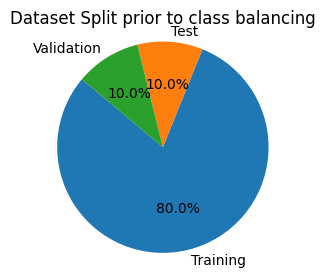

X_train contains 443840 rows, y_train contains 443840 rows
X_test  contains 55480 rows, y_test  contains 55480 rows
X_val   contains 55480 rows, y_val   contains 55480 rows


In [60]:
# create a pie chart showing relative sizes of X_train, X_test, X_val


# Labels for the pie chart
labels = ['Training', 'Test', 'Validation']

# Number of rows in each dataset split
sizes = [len(X_train), len(X_test), len(X_val)]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split prior to class balancing')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"X_train contains {len(X_train)} rows, y_train contains {len(y_train)} rows")
print(f"X_test  contains {len(X_test)} rows, y_test  contains {len(y_test)} rows")
print(f"X_val   contains {len(X_val)} rows, y_val   contains {len(y_val)} rows")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You will notice in the above chart that X_train has fewer rows than X_test or X_val")
  print(f"This should not be the case, because the dataset has not yet undergone any reduction in the size of the training set.")
  print(f"Please confirm that you are working on a clean dataset.")


This pie chart shows the class balance in the training data.
The y_train data is labeled as 0=normal 1=attack 

  normal class contains 323230 samples
abnormal class contains 120610 samples
This dataset is currently imbalanced, will be balanced in next section.


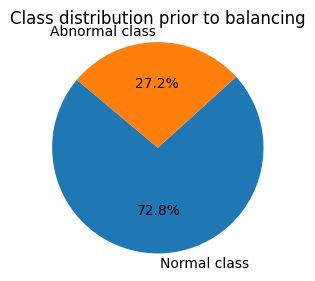

In [61]:
# create a pie chart showing the class balance in the training data

print(f"This pie chart shows the class balance in the training data.")
print(f"The y_train data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_train if value == 0)
abnormal_class = sum(1 for value in y_train if value == 1)
print(f"  normal class contains {normal_class} samples")
print(f"abnormal class contains {abnormal_class} samples")
if (normal_class == abnormal_class): print("WARNING: This dataset is not expected to be balanced yet.  Please investigate.")
if (normal_class != abnormal_class): print("This dataset is currently imbalanced, will be balanced in next section.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class distribution prior to balancing')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()





# Balance data classes

## SMOTE
This section is only shown as an example, this notebook balances the classes with random undersampling

In [62]:
# If you wanted to balance the classes with SMOTE instead, sample code shown below:

## Create an instance of the SMOTE class
#smote = SMOTE(sampling_strategy='auto')

## Apply SMOTE to the training data
#X_train_resampled, y_train_type_resampled = smote.fit_resample(X_train, y_train)

## sequential undersampling
This section is only shown as an example, this notebook balances the classes with random undersampling

In [63]:
# # sample code to perform sequential undersampling instead of random undersampling

# def sequential_undersample(X, y, minority_class_label, desired_ratio):
#     # Separate majority and minority class samples
#     majority_X = X[y != minority_class_label]
#     majority_y = y[y != minority_class_label]
#     minority_X = X[y == minority_class_label]
#     minority_y = y[y == minority_class_label]

#     print(f"Percentage of minority class samples in y: {sum(y == minority_class_label) / len(y) * 100:.2f}%")
#     print(f"Percentage of minority class samples in minority_y: {sum(minority_y == minority_class_label) / len(minority_y) * 100:.2f}%")

#     # Calculate the number of majority class samples to keep
#     num_minority_samples = len(minority_X)
#     #num_majority_samples = int(num_minority_samples * desired_ratio)
#     num_majority_samples = num_minority_samples

#     # Keep a portion of the majority class samples
#     majority_X_subset = majority_X[:num_majority_samples]
#     majority_y_subset = majority_y[:num_majority_samples]

#     # Combine minority and subset of majority class samples
#     X_balanced = np.concatenate((minority_X, majority_X_subset))
#     y_balanced = np.concatenate((minority_y, majority_y_subset))

#     return X_balanced, y_balanced

# # Usage example
# X_train_balanced, y_train_balanced = sequential_undersample(X_train, y_train, minority_class_label=1, desired_ratio=0.5)


# # Count the occurrences of each unique value
# normal_class   = sum(1 for value in y_train_balanced if value == 0)
# abnormal_class = sum(1 for value in y_train_balanced if value == 1)
# print(f"  normal class contains {normal_class} samples")
# print(f"abnormal class contains {abnormal_class} samples")

# # save the resampled values back to the original variable names so we can use consistent names throughout this notebook
# X_train = X_train_balanced
# y_train = y_train_balanced


## random undersampling

In [64]:
# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)

# Apply Random Under Sampling
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("Class balance before resampling")
print(y_train.value_counts())
print('\n')
print("Class balance after resampling")
print(y_train_resampled.value_counts())

# save the resampled values back to the original variable names so we can use consistent names throughout this notebook
X_train = X_train_resampled
y_train = y_train_resampled


Class balance before resampling
Attack_label
0    323230
1    120610
Name: count, dtype: int64


Class balance after resampling
Attack_label
0    120610
1    120610
Name: count, dtype: int64


In [65]:
# confirm the classes are balanced
# Figure out how many rows of each class exist in y_train (0=normal, 1=abnormal)

# Count occurrences of 0 and 1
normal_class   = sum(1 for value in y_train if value == 0)
abnormal_class = sum(1 for value in y_train if value == 1)

print(f"Count of   normal class: {normal_class}")
print(f"Count of abnormal class: {abnormal_class}")

total_rows = abnormal_class + normal_class
print(f"Total Number of rows (normal+abnormal): {total_rows}" )

balance = abnormal_class / total_rows * 100
balance = round(balance,2)

print(f"Percentage of abnormal class in dataset (abnormal/total*100): {balance}%")
if (balance  < 10): print("This dataset is very imbalanced, please beware of overfitting.")
if (balance != 50): print("WARNING: This dataset is supposed to be balanced.  Please investigate.")
if (balance == 50): print("This dataset is perfectly balanced.")

Count of   normal class: 120610
Count of abnormal class: 120610
Total Number of rows (normal+abnormal): 241220
Percentage of abnormal class in dataset (abnormal/total*100): 50.0%
This dataset is perfectly balanced.


In [66]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has", len(X_train), "samples")
print(f"y_train has", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")

# Sanity check to confirm X_test and y_test have equal number of samples
print('\n')
print(f"X_test has", len(X_test), "samples")
print(f"y_test has", len(y_test), "samples")
if ( len(X_test) != len(y_test) ):
  raise ValueError ("X_test and y_test are different lengths, please investigate!")

# Sanity check to confirm X_val and y_val have equal number of samples
print('\n')
print(f"X_val has", len(X_val), "samples")
print(f"y_val has", len(y_val), "samples")
if ( len(X_val) != len(y_val) ):
  raise ValueError ("X_val and y_val are different lengths, please investigate!")


X_train has 241220 samples
y_train has 241220 samples


X_test has 55480 samples
y_test has 55480 samples


X_val has 55480 samples
y_val has 55480 samples


In [67]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-13 17:24:13
The entire notebook runtime so far is 4 minutes


# Feature Scaling

In [68]:
# perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)  # Only transform the test       set, don't fit
X_val_scaled   = scaler.transform(X_val)   # Only transform the validation set, don't fit

# Save the values under original names so we can use consistent names in subsequent sections
X_train = X_train_scaled
X_test  = X_test_scaled
X_val   = X_val_scaled

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-13 17:24:13
The entire notebook runtime so far is 4 minutes


# Save progress in a pickle file
We don't actually use this pickle file anywhere, but it is nice to have available for debugging

In [69]:
import pickle

output_file = "Edge-IIoTset2023_scaled_data_tuple.pkl"
print(f"Saving progress to pickle file: ", output_file)

# Create a tuple
data_tuple = (X_train, X_test, X_val, y_train, y_test, y_val)

# Save the tuple using pickle
with open(output_file, 'wb') as f:
    pickle.dump(data_tuple, f)

Saving progress to pickle file:  Edge-IIoTset2023_scaled_data_tuple.pkl


In [70]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-13 17:24:14
The entire notebook runtime so far is 4 minutes


# Visualization after processing raw dataset

In [71]:
# sanity check

print(f"X_train contains {len(X_train)} rows, y_train contains {len(y_train)} rows")
print(f"X_test  contains {len(X_test)} rows, y_test  contains {len(y_test)} rows")
print(f"X_val   contains {len(X_val)} rows, y_val   contains {len(y_val)} rows")


X_train contains 241220 rows, y_train contains 241220 rows
X_test  contains 55480 rows, y_test  contains 55480 rows
X_val   contains 55480 rows, y_val   contains 55480 rows


In [72]:
# sanity check
X_train

array([[-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       ...,
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933]])

In [73]:
# sanity check
X_test

array([[-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       ...,
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933],
       [-0.05441588, -0.05772074, -0.27937865, ..., -0.16066521,
        -0.16401431, -0.00640933]])

In [74]:
# sanity check
y_train

0         0
1         0
2         0
3         0
4         0
         ..
241215    1
241216    1
241217    1
241218    1
241219    1
Name: Attack_label, Length: 241220, dtype: int64

In [75]:
# sanity check
y_test

1823867    1
1185711    0
79383      0
1955219    1
80875      0
          ..
1700219    1
1297275    0
855111     0
1452035    0
1547891    0
Name: Attack_label, Length: 55480, dtype: int64

In [76]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-13 17:24:14
The entire notebook runtime so far is 4 minutes


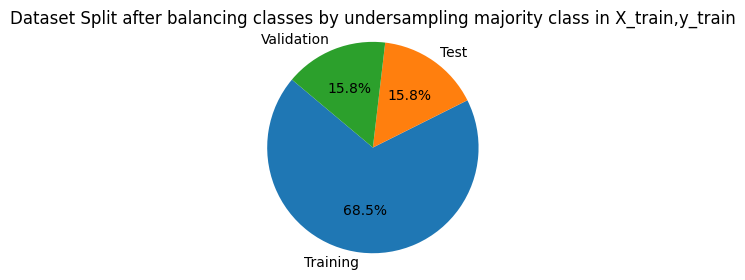

X_train contains 241220 rows, y_train contains 241220  rows
X_test  contains 55480 rows, y_test  contains 55480  rows
X_val   contains 55480 rows, y_val   contains 55480  rows
Please note that this data is after undersampling the majority class for balancing, so it is expected that the 80/10/10 split is changed here.


In [77]:
# create a pie chart showing relative sizes of X_train, X_test, X_val


# Labels for the pie chart
labels = ['Training', 'Test', 'Validation']

# Number of rows in each dataset split
sizes = [len(X_train), len(X_test), len(X_val)]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split after balancing classes by undersampling majority class in X_train,y_train')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"X_train contains", len(X_train), "rows, y_train contains", len(y_train), " rows")
print(f"X_test  contains", len(X_test), "rows, y_test  contains", len(y_test), " rows")
print(f"X_val   contains", len(X_val), "rows, y_val   contains", len(y_val), " rows")
print(f"Please note that this data is after undersampling the majority class for balancing, so it is expected that the 80/10/10 split is changed here.")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You will notice in the above chart that X_train has fewer rows than X_test or X_val")
  print(f"This should not be the case, because the dataset has not yet undergone any reduction in the size of the training set.")
  print(f"Please confirm that you are working on a clean dataset.")


This pie chart shows the class balance in the training data.
The y_train data is labeled as 0=normal 1=attack 

This dataset is perfectly balanced.


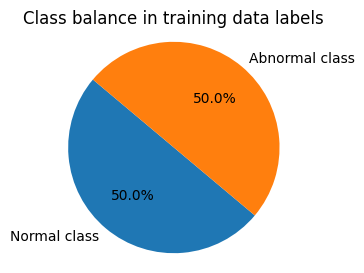

In [78]:
# create a pie chart showing the class balance in the training data

print(f"This pie chart shows the class balance in the training data.")
print(f"The y_train data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
normal_class   = sum(1 for value in y_train if value == 0)
abnormal_class = sum(1 for value in y_train if value == 1)
if (normal_class != abnormal_class): print("WARNING: This dataset is supposed to be balanced.  Please investigate.")
if (normal_class == abnormal_class): print("This dataset is perfectly balanced.")

# Extract labels and sizes for the pie chart
labels = ["Normal class", "Abnormal class"]
values = [normal_class, abnormal_class]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in training data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [79]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-13 17:24:14
The entire notebook runtime so far is 4 minutes


# Reduce dataset size to speed up analysis

NOTE: When reducing the size of your dataset to speed up training, it's generally recommended to sample only from the training data and leave the validation and test data untouched. Here's why:

Training Data:
- Sampling from the training data allows you to create a smaller subset that can be used for training the model.
- Since the training data is used to update the model's parameters during training, reducing its size can significantly speed up the training process without affecting the evaluation of the model.

Validation Data:
- The validation data is used to tune hyperparameters and monitor the model's performance during training.
- It's important to keep the validation data separate from the training data to ensure an unbiased evaluation of the model's performance.
- Sampling from the validation data could lead to overfitting on the validation set and biased performance estimates.

Test Data:
- Similarly, the test data serves as an unbiased evaluation of the model's performance on unseen data.
- Sampling from the test data could lead to overly optimistic performance estimates, as the model is evaluated on a different distribution than it will encounter in real-world scenarios.

In summary, while it's common to reduce the size of the training data to speed up training, it's important to keep the validation and test data separate and unchanged to ensure unbiased evaluation of the model's performance.

In [80]:
# save these values for comparison at the end of this section
X_train_len = len(X_train)  #re-calculate after subsampling
X_test_len  = len(X_test)   #re-calculate after subsampling
X_val_len   = len(X_val)    #re-calculate after subsampling
y_train_len = len(y_train)  #re-calculate after subsampling
y_test_len  = len(y_test)   #re-calculate after subsampling
y_val_len   = len(y_val)    #re-calculate after subsampling


print(f"X_train contains", len(X_train), "rows, y_train contains", len(y_train), " rows")
print(f"X_test  contains", len(X_test), "rows, y_test  contains", len(y_test), " rows")
print(f"X_val   contains", len(X_val), "rows, y_val   contains", len(y_val), " rows")

print(f"\nThe objective of this section is to see if we can speed up the training process by reducing the size of the dataset, but not losing too much accuracy.")

X_train contains 241220 rows, y_train contains 241220  rows
X_test  contains 55480 rows, y_test  contains 55480  rows
X_val   contains 55480 rows, y_val   contains 55480  rows

The objective of this section is to see if we can speed up the training process by reducing the size of the dataset, but not losing too much accuracy.


In [81]:
# Define a list of fractions to keep
#fractions_to_keep = [0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 1.0]
fractions_to_keep = [0.25, 0.50, 0.75, 1.0]


#initialize variables
best_accuracy         = 0
best_fraction_to_keep = 0
accuracy_001          = 0
accuracy_002          = 0
accuracy_005          = 0
accuracy_010          = 0
accuracy_025          = 0
accuracy_050          = 0
accuracy_075          = 0
accuracy_100          = 0

# Iterate through different fractions
for fraction_to_keep in fractions_to_keep:
    # Randomly subsample the training set
    num_samples_to_keep = int(len(X_train) * fraction_to_keep)
    random_indices = np.random.choice(len(X_train), num_samples_to_keep, replace=False)

    X_train_subsampled = X_train[random_indices]
    y_train_subsampled = y_train.iloc[random_indices]   #use .iloc becaue y_train is a 1-dimensional array

    # Train your model on the subsampled data
    #clf = LogisticRegression(max_iter=800, random_state=42)
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train_subsampled, y_train_subsampled)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on the test set (fraction_to_keep={fraction_to_keep:.4f}): {accuracy:.4f}")

    # Save the accuracy levels for later comparison
    if fraction_to_keep == 0.01: accuracy_001 = accuracy
    if fraction_to_keep == 0.02: accuracy_002 = accuracy
    if fraction_to_keep == 0.05: accuracy_005 = accuracy
    if fraction_to_keep == 0.10: accuracy_010 = accuracy
    if fraction_to_keep == 0.25: accuracy_025 = accuracy
    if fraction_to_keep == 0.50: accuracy_050 = accuracy
    if fraction_to_keep == 0.75: accuracy_075 = accuracy
    if fraction_to_keep == 1.0:  accuracy_100 = accuracy

    # keep track of the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fraction_to_keep = fraction_to_keep


print(f"The highest accuracy is {best_accuracy:.4f} using the {best_fraction_to_keep} fraction of the dataset\n")

# show a running total of elapsed time for the entire notebook
show_elapsed_time()


Accuracy on the test set (fraction_to_keep=0.2500): 0.8645
Accuracy on the test set (fraction_to_keep=0.5000): 0.8559
Accuracy on the test set (fraction_to_keep=0.7500): 0.8907
Accuracy on the test set (fraction_to_keep=1.0000): 0.9050
The highest accuracy is 0.9050 using the 1.0 fraction of the dataset

Current Time: 2024-05-13 17:31:39
The entire notebook runtime so far is 12 minutes


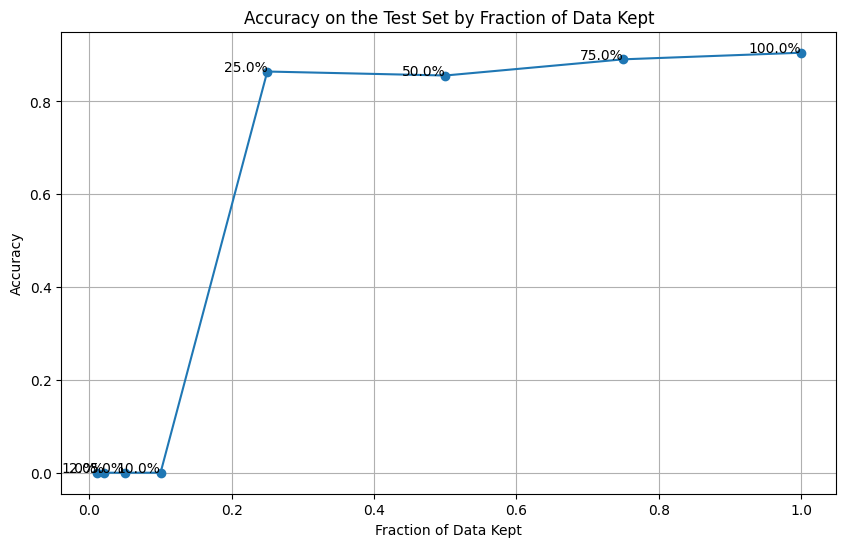

In [82]:
# Visualize the results from the previous cell

# Data extracted from the image
data = {
    'fraction_to_keep': [0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 1.00],
    'accuracy': [accuracy_001, accuracy_002, accuracy_005, accuracy_010, accuracy_025, accuracy_050, accuracy_075, accuracy_100]
}

# Create a DataFrame
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.plot(df['fraction_to_keep'], df['accuracy'], marker='o')

# Adding titles and labels
plt.title('Accuracy on the Test Set by Fraction of Data Kept')
plt.xlabel('Fraction of Data Kept')
plt.ylabel('Accuracy')

# Adding text for each data point
for i in range(len(df)):
    plt.text(df['fraction_to_keep'][i], df['accuracy'][i], f"{df['fraction_to_keep'][i]*100}%", ha='right')

# Adding grid for better readability
plt.grid(True)

# Save the figure with texts
fig_path_with_text = 'accuracy_vs_data_fraction_with_text.png'
plt.savefig(fig_path_with_text)

# Show the figure
plt.show()


In [83]:
# This cell will programnmatically determine the best_fraction_to_keep, by sacrificing some (small) amount of accuracy for speed.
# Exactly how small?  Let's go with an acceptable loss of 1% of accuracy for better speed.

acceptable_loss_of_accuracy = 0.0100  # 0.01*100= 1%  Tweak this value depending on how much accuracy you are willing to sacrifice

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_100):
    print(f"Using 100% of the dataset gives {accuracy_100*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 1.0

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_075):
    print(f"Using  75% of the dataset gives {accuracy_075*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.75

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_050):
    print(f"Using  50% of the dataset gives {accuracy_050*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.50

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_025):
    print(f"Using  25% of the dataset gives {accuracy_025*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.25

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_010):
    print(f"Using  10% of the dataset gives {accuracy_010*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.10

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_005):
    print(f"Using   5% of the dataset gives {accuracy_005*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.05

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_002):
    print(f"Using   2% of the dataset gives {accuracy_002*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.02

if ((best_accuracy - acceptable_loss_of_accuracy) <= accuracy_001):
    print(f"Using   1% of the dataset gives {accuracy_001*100:.2f}% accuracy, which is an acceptable trade-off between accuracy and speed.")
    best_fraction_to_keep = 0.01

print(f"\nBased on the above calculations, we will keep {best_fraction_to_keep*100:.0f}% of the dataset, which will still provide acceptable accuracy.")


Using 100% of the dataset gives 90.50% accuracy, which is an acceptable trade-off between accuracy and speed.

Based on the above calculations, we will keep 100% of the dataset, which will still provide acceptable accuracy.


In [84]:
# Based on the accuracy calculations in the previous cell, decide how much of the dataset to keep
fraction_to_keep = best_fraction_to_keep

# Randomly subsample the training set
num_samples_to_keep = int(len(X_train) * fraction_to_keep)
random_indices = np.random.choice(len(X_train), num_samples_to_keep, replace=False)

#save the sub-sampled data to temporary variable names
X_train_subsampled = X_train[random_indices]
y_train_subsampled = y_train.iloc[random_indices]   #use .iloc becaue y_train is a 1-dimensional array

#save the sub-sampled data back to the original variable names that are used in subsequent sections
X_train = X_train_subsampled
y_train = y_train_subsampled

print(f"\nPrior to downsampling the dataset sizes were:")
print(f"---------------------------------------------")
print(f"X_train previously contained {X_train_len} rows, y_train previously contained {y_train_len} rows")  #these values were calculated prior to subsampling
print(f"X_test  previously contained {X_test_len} rows, y_test  previously contained {y_test_len} rows")
print(f"X_val   previously contained {X_val_len} rows, y_val   previously contained {y_val_len} rows")



print(f"\nAfter downsampling the training data without losing too much accuracy, the new size of the dataset is:")
print(f"------------------------------------------------------------------------------------------------------")
X_train_len = len(X_train)  #re-calculate after subsampling
X_test_len  = len(X_test)   #re-calculate after subsampling
X_val_len   = len(X_val)    #re-calculate after subsampling
y_train_len = len(y_train)  #re-calculate after subsampling
y_test_len  = len(y_test)   #re-calculate after subsampling
y_val_len   = len(y_val)    #re-calculate after subsampling

print(f"X_train now contains {X_train_len} rows, y_train now contains {y_train_len} rows")  #these values were calculated prior to subsampling
print(f"X_test  now contains {X_test_len} rows, y_test  now contains {y_test_len} rows")
print(f"X_val   now contains {X_val_len} rows, y_val   now contains {y_val_len} rows")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You have reduced the size of X_train by too much!  X_train should not be smaller than X_test")
  print(f"This is because the training data was reduced via subsampling to speed up processing, but the test and validation data was not reduced in size.")
  print(f"Please go back to the dataset reduction setting and adjust the sizes of of the fractions_to_keep list")
  raise ValueError ("X_train has been reduced by too much, please investigate!")




Prior to downsampling the dataset sizes were:
---------------------------------------------
X_train previously contained 241220 rows, y_train previously contained 241220 rows
X_test  previously contained 55480 rows, y_test  previously contained 55480 rows
X_val   previously contained 55480 rows, y_val   previously contained 55480 rows

After downsampling the training data without losing too much accuracy, the new size of the dataset is:
------------------------------------------------------------------------------------------------------
X_train now contains 241220 rows, y_train now contains 241220 rows
X_test  now contains 55480 rows, y_test  now contains 55480 rows
X_val   now contains 55480 rows, y_val   now contains 55480 rows


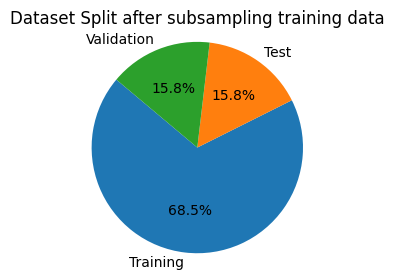

X_train contains 241220 rows, y_train contains 241220  rows
X_test  contains 55480 rows, y_test  contains 55480  rows
X_val   contains 55480 rows, y_val   contains 55480  rows


In [85]:
# create a pie chart showing relative sizes of X_train, X_test, X_val


# Labels for the pie chart
labels = ['Training', 'Test', 'Validation']

# Number of rows in each dataset split
sizes = [len(X_train), len(X_test), len(X_val)]

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Dataset Split after subsampling training data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"X_train contains", len(X_train), "rows, y_train contains", len(y_train), " rows")
print(f"X_test  contains", len(X_test), "rows, y_test  contains", len(y_test), " rows")
print(f"X_val   contains", len(X_val), "rows, y_val   contains", len(y_val), " rows")

if (len(X_train) < len(X_test)):
  print(f"\nWARNING: You have reduced the size of X_train by too much!  X_train should not be smaller than X_test")
  print(f"This is because the training data was reduced via subsampling to speed up processing, but the test and validation data was not reduced in size.")
  print(f"Please go back to the dataset reduction setting and adjust the sizes of of the fractions_to_keep list")
  raise ValueError ("X_train has been reduced by too much, please investigate!")


This pie chart shows the class balance in the training data.
The y_train data is labeled as 0=normal 1=attack 



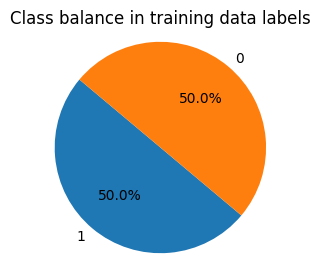

In [86]:
# create a pie chart showing the class balance in the training data

print(f"This pie chart shows the class balance in the training data.")
print(f"The y_train data is labeled as 0=normal 1=attack \n")

# Count the occurrences of each unique value
value_counts = Counter(y_train)    #assumes "from collections import Counter"

# Extract labels and sizes for the pie chart
labels = list(value_counts.keys())
sizes = list(value_counts.values())

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class balance in training data labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [87]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Current Time: 2024-05-13 17:31:40
The entire notebook runtime so far is 12 minutes


# Model training with traditional classifiers

## Logistic Regression

### default params
LR

Training model with default hyperparameters of: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.8752883922134103


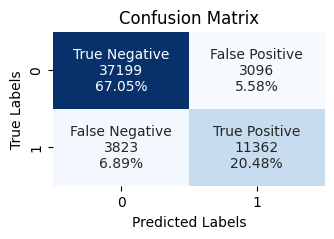




Confusion matrix

 [[37199  3096]
 [ 3823 11362]]

True Negatives  (TN) =  37199
False Positives (FP) =  3096
False Negatives (FN) =  3823
True Positives  (TP) =  11362


Accuracy:        0.8752883922134103
Sensitivity:     0.7482383931511359
Specificity:     0.9231666459858543
Geometric Mean:  0.8311129452746956


Precision:        0.8737035688284891
Recall:           0.8752883922134103
f1-score:         0.8743165855506778

------------------------------------------------

Current Time: 2024-05-13 17:31:43
The entire notebook runtime so far is 12 minutes


In [88]:
# Create an instance of the LogisticRegression model
clf = LogisticRegression()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_lr_unoptimized = accuracy

# call previously defined function to create confusion matrix
# We want to see approximately equal results from TN and TP
cm = visualize_confusion_matrix(y_test, y_pred)

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
LR

The LogisticRegression() class in scikit-learn provides several parameters that can be adjusted to customize the logistic regression model. Here are some of the commonly used parameters:
- penalty: Specifies the norm used in the penalization. It can take values like 'l1' (L1 regularization), 'l2' (L2 regularization), or 'none' (no regularization). The default is 'l2'.
- C: Inverse of regularization strength. Smaller values specify stronger regularization. The default value is 1.0.
- solver: Algorithm to use in the optimization problem. Options include 'liblinear', 'newton-cg', 'lbfgs', 'sag', and 'saga'. The default is 'lbfgs'.
- max_iter: Maximum number of iterations taken for the solvers to converge. The default is 100.
- multi_class: Specifies the strategy to use for multiclass classification. Options include 'auto', 'ovr' (one-vs-rest), and 'multinomial' (softmax). The default is 'auto'.
- verbose: Controls the verbosity of the output. Set to an integer value greater than 0 for more verbosity. The default is 0.
- random_state: Seed used by the random number generator. It ensures reproducibility of results. Set to an integer for reproducible output. The default is None.
- tol: Tolerance for stopping criteria. The default is 1e-4.
class_weight: Weights associated with classes. This can be used to handle class imbalance by assigning higher weights to minority classes.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call 

Best Parameters: {'C': 1.0, 'max_iter': 200, 'multi_class': 'auto', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
Best Scores: 0.8362241936821159


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Cross validation scores: [0.83720255 0.83728547 0.83740983 0.83840478 0.83720255 0.8340519
 0.83401045 0.83517121 0.8364978  0.83500539]
Mean cross validation score: 0.8362241936821159
Standard Deviation cross validation score: 0.0014659464825269356
Accuracy: 0.8752883922134103


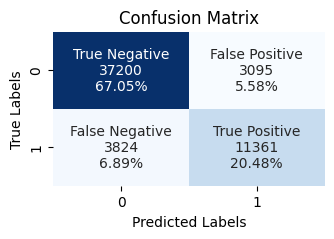




Confusion matrix

 [[37200  3095]
 [ 3824 11361]]

True Negatives  (TN) =  37200
False Positives (FP) =  3095
False Negatives (FN) =  3824
True Positives  (TP) =  11361


Accuracy:        0.8752883922134103
Sensitivity:     0.7481725386894962
Specificity:     0.9231914629606651
Geometric Mean:  0.8310875408401637


Precision:        0.8736999891998449
Recall:           0.8752883922134103
f1-score:         0.8743137948599431

------------------------------------------------

Current Time: 2024-05-13 17:38:39
The entire notebook runtime so far is 19 minutes


In [89]:
# Create an instance of the  model
clf = LogisticRegression()

# Define the hyperparameters to tune
param_grid = {
    'penalty': ['None', 'l2'],
    'C': [0.1, 1.0],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200],
    'multi_class': ['auto'],
    'random_state': [42]                 #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = LogisticRegression(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
lr_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
lr_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
lr_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_lr = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_lr_optimized      = Accuracy
sensitivity_lr_optimized   = Sensitivity
specificity_lr_optimized   = Specificity
geometricmean_lr_optimized = GeometricMean
precision_lr_optimized     = Precision
recall_lr_optimized        = Recall
f1_lr_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Naive Bayes

### default params
NB

Training model with default hyperparameters of: {'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}
Accuracy: 0.7695205479452055


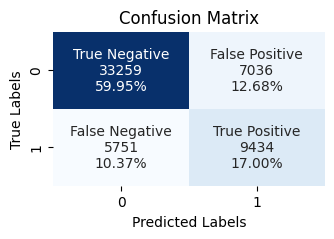




Confusion matrix

 [[33259  7036]
 [ 5751  9434]]

True Negatives  (TN) =  33259
False Positives (FP) =  7036
False Negatives (FN) =  5751
True Positives  (TP) =  9434


Accuracy:        0.7695205479452055
Sensitivity:     0.6212709911096477
Specificity:     0.8253877652314183
Geometric Mean:  0.7160932027013666


Precision:        0.7760006082487145
Recall:           0.7695205479452055
f1-score:         0.7723313182873869

------------------------------------------------

Current Time: 2024-05-13 17:38:40
The entire notebook runtime so far is 19 minutes


In [90]:

# Create an instance of the model
#clf = GaussianNB()    # suitable for continuous features
#clf = MultinomialNB() # used for discrete data like word counts
clf = BernoulliNB()    # suitable for binary data, gives best accuracy for this dataset

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_nb_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_nb_unoptimized      = Accuracy
sensitivity_nb_unoptimized   = Sensitivity
specificity_nb_unoptimized   = Specificity
geometricmean_nb_unoptimized = GeometricMean
precision_nb_unoptimized     = Precision
recall_nb_unoptimized        = Recall
f1_nb_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
NB

he BernoulliNB class in scikit-learn represents a naive Bayes classifier for Bernoulli-distributed data. Here are the parameters of the BernoulliNB class:

- alpha: (float, default=1.0 or 1e-10)
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
- binarize: (float or None, default=None)
Threshold for binarizing (mapping to boolean) of sample features. If None, no binarization is performed.
- fit_prior: (bool, default=True)
Whether to learn class prior probabilities or not. If False, a uniform prior will be used.
- class_prior: (array-like of shape (n_classes,), default=None)
Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.
- min_df: (float or int, default=1)
When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature.
- max_df: (float or int, default=1.0)
When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts.
- max_features: (int, default=None)
If not None, build a vocabulary that only considers the top max_features ordered by term frequency across the corpus.
- binary: (bool, default=False)
Whether to treat all values greater than zero as 1, and all others as 0.
- n_jobs: (int, default=None)
The number of parallel jobs to run. -1 means using all processors.


These parameters allow you to customize the behavior of the Bernoulli Naive Bayes classifier according to your specific needs and the characteristics of your data.

Performing GridSearchCV
Best Parameters: {'alpha': 0.1}
Best Scores: 0.722270126855153
Fitting the model
Cross validation scores: [0.72328165 0.72552027 0.72340602 0.72394495 0.72705414 0.71955062
 0.71826548 0.7176851  0.7215405  0.72245253]
Mean cross validation score: 0.722270126855153
Standard Deviation cross validation score: 0.0028911879615516225
Accuracy: 0.7695205479452055


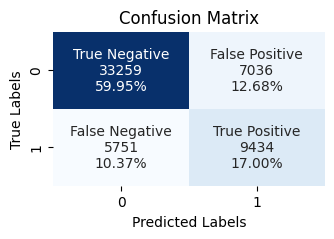




Confusion matrix

 [[33259  7036]
 [ 5751  9434]]

True Negatives  (TN) =  33259
False Positives (FP) =  7036
False Negatives (FN) =  5751
True Positives  (TP) =  9434


Accuracy:        0.7695205479452055
Sensitivity:     0.6212709911096477
Specificity:     0.8253877652314183
Geometric Mean:  0.7160932027013666


Precision:        0.7760006082487145
Recall:           0.7695205479452055
f1-score:         0.7723313182873869

------------------------------------------------

Current Time: 2024-05-13 17:38:52
The entire notebook runtime so far is 19 minutes


In [91]:
# Create an instance of the model
clf = BernoulliNB()

# Define the hyperparameters to tune
# skip the sigmoid and poly kernels, rarely used
param_grid = {
    'alpha': [1.0, 0.1, 0.01, 0.001]
}


# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print("Performing GridSearchCV")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of model with the best hyperparameters
clf = BernoulliNB(**best_params)

# Fit the model to the training data
print("Fitting the model")
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
nb_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
nb_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
nb_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_nb = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_nb_optimized      = Accuracy
sensitivity_nb_optimized   = Sensitivity
specificity_nb_optimized   = Specificity
geometricmean_nb_optimized = GeometricMean
precision_nb_optimized     = Precision
recall_nb_optimized        = Recall
f1_nb_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

# KNN

### default params
KNN

Training model with default hyperparameters of: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.8564167267483778


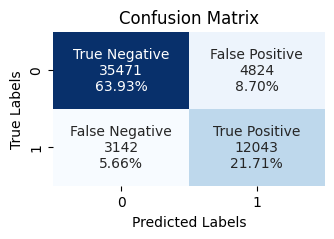




Confusion matrix

 [[35471  4824]
 [ 3142 12043]]

True Negatives  (TN) =  35471
False Positives (FP) =  4824
False Negatives (FN) =  3142
True Positives  (TP) =  12043


Accuracy:        0.8564167267483778
Sensitivity:     0.7930852815278235
Specificity:     0.8802829135128428
Geometric Mean:  0.835547378840641


Precision:        0.862620562860621
Recall:           0.8564167267483778
f1-score:         0.858653844719164

------------------------------------------------

Current Time: 2024-05-13 17:42:02
The entire notebook runtime so far is 22 minutes


In [92]:
# Create an instance of the model with the desired number of neighbors (you can adjust n_neighbors)
clf = KNeighborsClassifier(n_neighbors=5)  # You can change the value of n_neighbors as needed

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_knn_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_knn_unoptimized      = Accuracy
sensitivity_knn_unoptimized   = Sensitivity
specificity_knn_unoptimized   = Specificity
geometricmean_knn_unoptimized = GeometricMean
precision_knn_unoptimized     = Precision
recall_knn_unoptimized        = Recall
f1_knn_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
KNN

In [93]:
# # Create an instance of the model
# clf = KNeighborsClassifier()

# # Define the hyperparameters to tune
# param_grid = {
#     'n_neighbors': [5,10,15,20,30],
#     'weights': ['uniform', 'distance']
# }



# # Create an instance of GridSearchCV
# grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# # Fit the grid search to the training data
# print(f"Performing grid_search to find optimal parameters")
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# best_scores = grid_search.best_score_
# print("Best Parameters:", best_params)
# print("Best Scores:", best_scores)

# # Create a new instance of the model with the best hyperparameters
# clf = KNeighborsClassifier(**best_params)

# # Fit the model to the training data
# clf.fit(X_train, y_train)

# # Predict the labels for the test data
# y_pred = clf.predict(X_test)

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# knn_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# knn_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# knn_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the model
# Accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", Accuracy)

# # save best parameters for later comparison
# best_params_knn = best_params

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_knn_optimized      = Accuracy
# sensitivity_knn_optimized   = Sensitivity
# specificity_knn_optimized   = Specificity
# geometricmean_knn_optimized = GeometricMean
# precision_knn_optimized     = Precision
# recall_knn_optimized        = Recall
# f1_knn_optimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

## SVM

### default params
SVM

In [94]:
# # Create an instance of the model
# clf = SVC()

# default_params = clf.get_params()
# print(f"Training model with default hyperparameters of: {default_params}")

# # Fit the model to the training data
# clf.fit(X_train, y_train)

# # Predict the labels for the test data
# y_pred = clf.predict(X_test)

# # Evaluate the model
# accuracy = clf.score(X_test, y_test)
# print("Accuracy:", accuracy)

# # save accuracy for later comparison
# accuracy_svm_undersampled_unoptimized = accuracy

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_svm_unoptimized      = Accuracy
# sensitivity_svm_unoptimized   = Sensitivity
# specificity_svm_unoptimized   = Specificity
# geometricmean_svm_unoptimized = GeometricMean
# precision_svm_unoptimized     = Precision
# recall_svm_unoptimized        = Recall
# f1_svm_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

### optimized params
SVM

In [95]:
print("WARNING: SVM hyperparameter optimization is very CPU-intensive, this will take some time...")

# use the accuracy value prior to hyperparameter optimization so we still have something to copmare to at the end of this notebook
accuracy_svm_optimized = accuracy_svm_unoptimized

In [96]:
# # Create an instance of the model
# clf = SVC()

# # Define the hyperparameters to tune
# # skip the sigmoid and poly kernels, rarely used
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['rbf', 'linear'],
#     'probability': [True],               #probability=True is required for VotingClassifier
#     'random_state': [42]                 #for reproducible results
# }



# # Create an instance of GridSearchCV
# grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# # Fit the grid search to the training data
# print("Performing GridSearchCV")
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# best_scores = grid_search.best_score_
# print("Best Parameters:", best_params)
# print("Best Scores:", best_scores)

# # Create a new instance of model with the best hyperparameters
# clf = SVC(**best_params)

# # Fit the model to the training data
# print("Fitting the model")
# clf.fit(X_train, y_train)

# # Predict the labels for the test data
# y_pred = clf.predict(X_test)

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# svm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# svm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# svm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the model
# Accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", Accuracy)

# # save best parameters for later comparison
# best_params_svm = best_params

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_svm_optimized      = Accuracy
# sensitivity_svm_optimized   = Sensitivity
# specificity_svm_optimized   = Specificity
# geometricmean_svm_optimized = GeometricMean
# precision_svm_optimized     = Precision
# recall_svm_optimized        = Recall
# f1_svm_optimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

## Decision Tree

### default params

Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy: 0.934030281182408


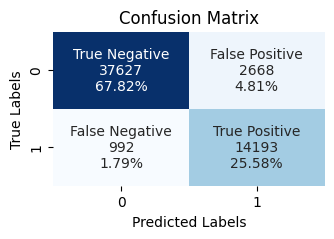




Confusion matrix

 [[37627  2668]
 [  992 14193]]

True Negatives  (TN) =  37627
False Positives (FP) =  2668
False Negatives (FN) =  992
True Positives  (TP) =  14193


Accuracy:        0.934030281182408
Sensitivity:     0.9346723740533421
Specificity:     0.9337883112048642
Geometric Mean:  0.9342302380554333


Precision:        0.9380344391865612
Recall:           0.934030281182408
f1-score:         0.9350548406881858

------------------------------------------------

Current Time: 2024-05-13 17:42:04
The entire notebook runtime so far is 22 minutes


In [97]:
# Create an instance of the DecisionTreeClassifier model
clf = DecisionTreeClassifier()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_dt_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_dt_unoptimized      = Accuracy
sensitivity_dt_unoptimized   = Sensitivity
specificity_dt_unoptimized   = Specificity
geometricmean_dt_unoptimized = GeometricMean
precision_dt_unoptimized     = Precision
recall_dt_unoptimized        = Recall
f1_dt_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
DT

Performing grid_search to find optimal parameters
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'random_state': 42}
Best Scores: 0.936278086394163
Cross validation scores: [0.93632369 0.9367797  0.93706989 0.93727717 0.93267557 0.93549457
 0.9367797  0.93628223 0.93586767 0.93823066]
Mean cross validation score: 0.936278086394163
Standard Deviation cross validation score: 0.001403691992351983
Accuracy: 0.9401405912040375


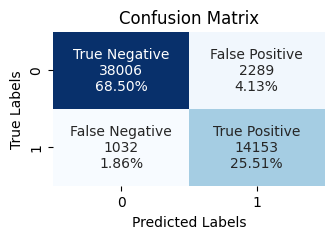




Confusion matrix

 [[38006  2289]
 [ 1032 14153]]

True Negatives  (TN) =  38006
False Positives (FP) =  2289
False Negatives (FN) =  1032
True Positives  (TP) =  14153


Accuracy:        0.9401405912040375
Sensitivity:     0.932038195587751
Specificity:     0.9431939446581462
Geometric Mean:  0.937599478598656


Precision:        0.9426958460842799
Recall:           0.9401405912040375
f1-score:         0.9408559086758287

------------------------------------------------

Current Time: 2024-05-13 17:57:58
The entire notebook runtime so far is 38 minutes


In [98]:
# Create an instance of the DecisionTreeClassifier model
clf = DecisionTreeClassifier()

# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]                 #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count,n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print(f"Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = DecisionTreeClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
dt_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
dt_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
dt_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_dt = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_dt_optimized      = Accuracy
sensitivity_dt_optimized   = Sensitivity
specificity_dt_optimized   = Specificity
geometricmean_dt_optimized = GeometricMean
precision_dt_optimized     = Precision
recall_dt_optimized        = Recall
f1_dt_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Random Forest

### default params

Training model with default hyperparameters of: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9415645277577506


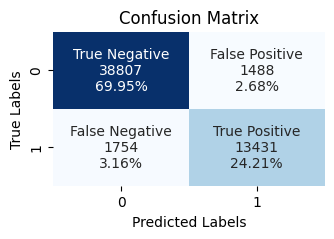




Confusion matrix

 [[38807  1488]
 [ 1754 13431]]

True Negatives  (TN) =  38807
False Positives (FP) =  1488
False Negatives (FN) =  1754
True Positives  (TP) =  13431


Accuracy:        0.9415645277577506
Sensitivity:     0.8844912742838328
Specificity:     0.9630723414815734
Geometric Mean:  0.9229458719472943


Precision:        0.9412936609425362
Recall:           0.9415645277577506
f1-score:         0.941402479299903

------------------------------------------------

Current Time: 2024-05-13 17:58:22
The entire notebook runtime so far is 39 minutes


In [99]:
# Create an instance of the RandomForestClassifier model
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_rf_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_rf_unoptimized      = Accuracy
sensitivity_rf_unoptimized   = Sensitivity
specificity_rf_unoptimized   = Specificity
geometricmean_rf_unoptimized = GeometricMean
precision_rf_unoptimized     = Precision
recall_rf_unoptimized        = Recall
f1_rf_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
RF

The RandomForestClassifier() class in scikit-learn provides several parameters that can be adjusted to customize the random forest model. Here are some of the commonly used parameters:

- n_estimators: The number of trees in the forest. Higher values usually yield better performance, but also increase computational cost. The default is 100.
- criterion: The function used to measure the quality of a split. It can be 'gini' for the Gini impurity or 'entropy' for the information gain. The default is 'gini'.
- max_depth: The maximum depth of the tree. If None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. The default is None.
- min_samples_split: The minimum number of samples required to split an internal node. The default is 2.
min_samples_leaf: The minimum number of samples required to be at a leaf node. The default is 1.
Vmax_features: The number of features to consider when looking for the best split. It can be 'auto' (sqrt(n_features)), 'sqrt' (sqrt(n_features)), 'log2' (log2(n_features)), or a number between 0 and 1 (fraction of total features). The default is 'auto'.
- bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. The default is True.
- random_state: Seed used by the random number generator. It ensures reproducibility of results. Set to an integer for reproducible output. The default is None.
- n_jobs: The number of jobs to run in parallel for both fit and predict. -1 means using all processors. The default is 1.
- verbose: Controls the verbosity of the output. Set to an integer value greater than 0 for more verbosity. The default is 0.
- class_weight: Weights associated with classes. This can be used to handle class imbalance by assigning higher weights to minority classes.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Best Parameters: {'criterion': 'entropy', 'random_state': 42}
Best Scores: 0.9228919658403119
Cross validation scores: [0.92430147 0.9245502  0.92367963 0.92575243 0.92193848 0.92123373
 0.92036315 0.92040461 0.92251886 0.9241771 ]
Mean cross validation score: 0.9228919658403119
Standard Deviation cross validation score: 0.001776811126087129
Accuracy: 0.9412941600576784


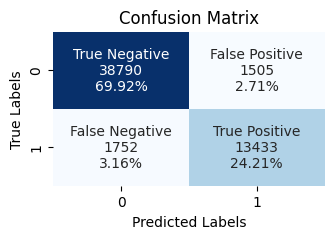




Confusion matrix

 [[38790  1505]
 [ 1752 13433]]

True Negatives  (TN) =  38790
False Positives (FP) =  1505
False Negatives (FN) =  1752
True Positives  (TP) =  13433


Accuracy:        0.9412941600576784
Sensitivity:     0.8846229832071123
Specificity:     0.9626504529097903
Geometric Mean:  0.9228123944977855


Precision:        0.9410380096541042
Recall:           0.9412941600576784
f1-score:         0.9411431632656978

------------------------------------------------

Current Time: 2024-05-13 18:13:21
The entire notebook runtime so far is 54 minutes


In [100]:
# Create an instance of the RandomForestClassifier model
clf = RandomForestClassifier(n_jobs=-1)

# Define the hyperparameters to tune
param_grid = {
    #'n_estimators': [100, 200, 300, 500],
    'criterion': ['gini', 'entropy'],
    #'max_depth': ['None', 5, 10],
    #'class_weight': ['None', 'balanced'],
    'random_state': [42]                 #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = RandomForestClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
rf_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
rf_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
rf_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_rf = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_rf_optimized      = Accuracy
sensitivity_rf_optimized   = Sensitivity
specificity_rf_optimized   = Specificity
geometricmean_rf_optimized = GeometricMean
precision_rf_optimized     = Precision
recall_rf_optimized        = Recall
f1_rf_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Gradient Boosting

Gradient Boosting is a popular machine learning technique used for both regression and classification tasks. It is an ensemble learning method that builds a strong predictive model by combining the predictions of multiple weaker models, typically decision trees. Here's how gradient boosting works:

1. Base Learners (Weak Models): Gradient Boosting combines the predictions of multiple weak models, often decision trees, to create a strong predictive model. These weak models are referred to as base learners or weak learners.
2. Sequential Training: Gradient Boosting trains the weak models sequentially. Each new model is trained to correct the errors made by the previous models.
3. Loss Function: During training, Gradient Boosting minimizes a loss function, which measures the difference between the actual target values and the predicted values of the ensemble model. Common loss functions include mean squared error (MSE) for regression tasks and cross-entropy loss for classification tasks.
4. Gradient Descent Optimization: Gradient Boosting optimizes the loss function using gradient descent. In each iteration, the algorithm calculates the gradient of the loss function with respect to the current predictions and adjusts the predictions in the direction that minimizes the loss.
5. Gradient Boosting Algorithm:
- Initialize the ensemble model with a simple base learner (e.g., a decision stump).
- Train the base learner on the training data and calculate the residuals (the differences between the actual and predicted values).
- Fit a new base learner to the residuals, focusing on the areas where the previous model made errors.
- Combine the predictions of all base learners to make the final ensemble prediction.
- Repeat the process until a predefined number of base learners have been added, or until the loss function converges.
6. Regularization: Gradient Boosting typically includes regularization techniques to prevent overfitting, such as limiting the depth of the trees, adding shrinkage (learning rate), and using subsampling (training on random subsets of the data).
7. Hyperparameter Tuning: Gradient Boosting involves tuning several hyperparameters, such as the learning rate, tree depth, number of trees, and regularization parameters, to optimize the performance of the model.
8. Scalability: Gradient Boosting can handle large datasets and high-dimensional feature spaces. However, training time and memory usage can increase with the complexity of the model and the size of the dataset.


Overall, Gradient Boosting is a powerful and versatile technique that often achieves state-of-the-art performance on a wide range of machine learning tasks. It is widely used in practice due to its effectiveness and ease of implementation. Popular implementations of Gradient Boosting include XGBoost, LightGBM, and CatBoost.

### default params
GB

Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9542177361211247


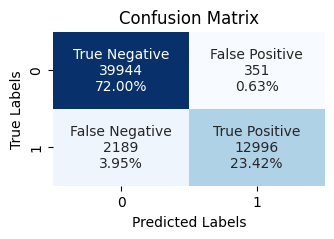




Confusion matrix

 [[39944   351]
 [ 2189 12996]]

True Negatives  (TN) =  39944
False Positives (FP) =  351
False Negatives (FN) =  2189
True Positives  (TP) =  12996


Accuracy:        0.9542177361211247
Sensitivity:     0.8558445834705302
Specificity:     0.9912892418414195
Geometric Mean:  0.9210806307173044


Precision:        0.9550677110863615
Recall:           0.9542177361211247
f1-score:         0.9532535467666314

------------------------------------------------

Current Time: 2024-05-13 18:14:20
The entire notebook runtime so far is 55 minutes


In [101]:
# Create an instance of the model
clf = GradientBoostingClassifier(random_state=42)

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_gb_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test, y_pred)

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
GB

In [ ]:
# Create an instance of the model
clf = GradientBoostingClassifier()

#default_params = clf.get_params()
#print(f"Training model with default hyperparameters of: {default_params}")

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100],               #10,200 reduced accuracy
    'learning_rate': [0.1, 1.0],
    'max_depth': [3],                    #add higher numbers reduces accuracy
    'random_state': [42]                 #for reproducible results
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print(f"Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
print(f"Fitting the model with these parameters: {best_params}")
clf = GradientBoostingClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
gb_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
gb_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
gb_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model
Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", Accuracy)

# save best parameters for later comparison
best_params_gb = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_gb_optimized      = Accuracy
sensitivity_gb_optimized   = Sensitivity
specificity_gb_optimized   = Specificity
geometricmean_gb_optimized = GeometricMean
precision_gb_optimized     = Precision
recall_gb_optimized        = Recall
f1_gb_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

Performing grid_search to find optimal parameters


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



# Compare accuracy of LR, NB, KNN, SVM, DT, GB, RF

In [ ]:
# this section compares the accuracy of different methods:

from tabulate import tabulate
# Define headers for the table
headers = ["Model", "Accuracy Un-optimized", "Accuracy Optimized"]
# Define data for the trable
data = [
    ["LR",  accuracy_lr_unoptimized,   accuracy_lr_optimized],
    ["NB",  accuracy_nb_unoptimized,   accuracy_nb_optimized],
    ["KNN", accuracy_knn_unoptimized,  accuracy_knn_optimized],
    ["SVM", accuracy_svm_unoptimized,  accuracy_svm_optimized],
    ["DT",  accuracy_dt_unoptimized,   accuracy_dt_optimized],
    ["RF",  accuracy_rf_unoptimized,   accuracy_rf_optimized],
    ["GB",  accuracy_gb_unoptimized,   accuracy_gb_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


# sanity checks to confirm that hyperparameter optimization did not make things worse instead of better
if accuracy_lr_unoptimized  > accuracy_lr_optimized:  print("WARNING: LR optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_nb_unoptimized  > accuracy_nb_optimized:  print("WARNING: NB optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_knn_unoptimized > accuracy_knn_optimized: print("WARNING: KNN optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_svm_unoptimized > accuracy_svm_optimized: print("WARNING: SVM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_dt_unoptimized  > accuracy_dt_optimized:  print("WARNING: DT optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_rf_unoptimized  > accuracy_rf_optimized:  print("WARNING: RF optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_gb_unoptimized  > accuracy_gb_optimized:  print("WARNING: GB optimization made the accuracy worse, please tweak hyperparameters")


# Model training with Deep Learning classifiers

## MLP Multi-Layer Perceptron

MLPClassifier is a class in scikit-learn that represents a Multi-layer Perceptron (MLP) classifier, which is a type of artificial neural network.

An MLP is a feedforward neural network that consists of multiple layers of nodes (neurons) and can learn complex patterns and relationships in data.

The MLPClassifier is specifically designed for classification tasks.

Example of all hyperparameters:
- hidden_layer_sizes=(100, 50),  # Architecture of hidden layers
- activation='relu',             # Activation function ('relu' is common)
- solver='adam',                 # Optimization solver
- alpha=0.0001,                  # L2 penalty (regularization)
- batch_size='auto',             # Size of mini-batches ('auto' is adaptive)
- learning_rate='constant',      # Learning rate schedule
- learning_rate_init=0.001,      # Initial learning rate
- max_iter=500,                  # Maximum number of iterations
- shuffle=True,                  # Shuffle data in each iteration
- random_state=42,               # Random seed for reproducibility
- verbose=True                   # Print progress during training


Multi-Layer Perceptron (MLP) classifier with three or more hidden layers is typically considered a deep learning model. The term "deep" in deep learning refers to the presence of multiple layers in the neural network architecture. While there's no strict definition of how many layers constitute a "deep" network, models with three or more hidden layers are commonly regarded as deep neural networks.

MLP classifiers, being feedforward neural networks (FNN) with multiple layers, can learn complex patterns and representations from data, making them suitable for various classification tasks. The depth of the network allows it to learn hierarchical features and capture intricate relationships within the data, leading to improved performance on tasks with large and complex datasets.

https://en.wikipedia.org/wiki/Feedforward_neural_network
A feedforward neural network (FNN) is one of the two broad types of artificial neural network, characterized by direction of the flow of information between its layers.[2] Its flow is uni-directional, meaning that the information in the model flows in only one direction—forward—from the input nodes, through the hidden nodes (if any) and to the output nodes, without any cycles or loops,[2] in contrast to recurrent neural networks,[3] which have a bi-directional flow. Modern feedforward networks are trained using the backpropagation method[4][5][6][7][8] and are colloquially referred to as the "vanilla" neural networks.[9]







In [ ]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has ", len(X_train), "samples")
print(f"y_train has ", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")


### default params
MLP


In [ ]:
# Create an instance of the model
clf = MLPClassifier(random_state=42)   #hidden_layer_sizes can be added here as tuples, see hyperparameter cell for an example

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model on training data
print(f"-----------------------------------------")
train_accuracy = clf.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Evaluate the model on test data
test_accuracy = clf.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on val data
val_accuracy = clf.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)
print(f"-----------------------------------------")

# save results calculated for this model for later comparison to other models
test_accuracy_mlp_unoptimized  = test_accuracy
train_accuracy_mlp_unoptimized = train_accuracy
val_accuracy_mlp_unoptimized   = val_accuracy

# save accuracy for later comparison
accuracy_mlp_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_mlp_unoptimized      = Accuracy
sensitivity_mlp_unoptimized   = Sensitivity
specificity_mlp_unoptimized   = Specificity
geometricmean_mlp_unoptimized = GeometricMean
precision_mlp_unoptimized     = Precision
recall_mlp_unoptimized        = Recall
f1_mlp_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
MLP

In [ ]:

# Create an instance of the model
clf = MLPClassifier()

# Define the hyperparameters to tune
param_grid = {
    'hidden_layer_sizes': [(100,)],  #also tried (64,32)), (64,32,16), (128,64,32) as tuples for hidden layers, but default (100,) was best
    'max_iter': [200],                        # also tried 100, 300
    'alpha': [0.0001],                        #also tried 0.001, 0.01
    'activation': ['relu'],                   #also tried tanh
    'learning_rate': ['constant'],            #also tried adaptive
    'random_state': [42]                      #for reproducible results
}



# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1, verbose=verbosity)

# Fit the grid search to the training data
print(f"Performing grid_search to find optimal parameters")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = MLPClassifier(**best_params)

# Fit the model to the training data
print(f"Fitting the model with best_params {best_params}")
clf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
mlp_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
mlp_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
mlp_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"-----------------------------------------")
train_accuracy = clf.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Evaluate the model on test data
test_accuracy = clf.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on val data
val_accuracy = clf.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)
print(f"-----------------------------------------")

# save results calculated for this model for later comparison to other models
test_accuracy_mlp_optimized  = test_accuracy
train_accuracy_mlp_optimized = train_accuracy
val_accuracy_mlp_optimized   = val_accuracy


# save best parameters for later comparison
best_params_mlp = best_params

# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_mlp_optimized      = Accuracy
sensitivity_mlp_optimized   = Sensitivity
specificity_mlp_optimized   = Specificity
geometricmean_mlp_optimized = GeometricMean
precision_mlp_optimized     = Precision
recall_mlp_optimized        = Recall
f1_mlp_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Sequential FNN
(does not require time steps)



In the context of the Keras library, Sequential() is not a classifier itself, but rather a type of model architecture. It is used to create sequential models, which are a linear stack of layers.

These models are typically used for building feedforward neural networks (FNNs), where the data flows sequentially from the input layer through one or more hidden layers to the output layer. Each layer in a sequential model has connections only to the layers that follow it in the model.

You can use different types of layers such as Dense, Dropout, Conv1D, Conv2D, LSTM, etc., in a Sequential() model depending on the type of problem you are solving. Once the layers are added to the model, you compile it with an optimizer, a loss function, and optionally, performance metrics. After compilation, you can train the model on your data using the fit() method.

In [ ]:
# row, columns in X_train
print(X_train.shape)

In [ ]:
# sanity check
print(X_train)

In [ ]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has ", len(X_train), "samples")
print(f"y_train has ", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")


### default params

In [ ]:
# row, columns in X_train
print(X_train.shape)

In [ ]:
# # no better than previous cell

# # Sequential (prior to optimization) -- New test - Backup stable version - with validation


# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]


# # Define the model
# model = Sequential([                                           #Initializes a sequential neural network model
#     Dense(64, activation='relu', input_shape=(input_shape,)),  #Add a fully connected layer (also known as a dense layer) with 64 neurons
#     Dropout(0.5),                                              #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
#     Dense(32, activation='tanh'),                              #Adds another fully connected layer with 32 neurons and RtanheLU activation function.
#     Dense(1, activation='sigmoid')                             # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_data=(X_val, y_val))

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # save results calculated for this model for later comparison to other models
# test_accuracy_sequential_unoptimized  = test_accuracy
# test_loss_sequential_unoptimized      = test_loss
# train_accuracy_sequential_unoptimized = train_accuracy
# train_loss_sequential_unoptimized     = train_loss

# # call previously defined function to create confusion matrix
# cm = visualize_confusion_matrix(y_test, y_pred)

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# # no better than previous cell

# # Sequential (prior to optimization) -- New test


# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# # Define the model
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(input_shape,)),
#     Dropout(0.5),  # Optional dropout layer for regularization
#     Dense(64, activation='tanh'),
#     Dropout(0.5),
#     Dense(32, activation='tanh'),
#     Dropout(0.5),
#     Dense(16, activation='tanh'),   # add another hidden layer
#     Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_data=(X_val, y_val))

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # save results calculated for this model for later comparison to other models
# test_accuracy_sequential_unoptimized  = test_accuracy
# test_loss_sequential_unoptimized      = test_loss
# train_accuracy_sequential_unoptimized = train_accuracy
# train_loss_sequential_unoptimized     = train_loss

# # call previously defined function to create confusion matrix
# cm = visualize_confusion_matrix(y_test, y_pred)

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# # no better than previous cell

# # Test FNN on different activation functions:

# # Define a list of activation functions to test
# activation_functions = ['sigmoid', 'linear', 'tanh', 'relu']
# activation_functions = ['relu']  #after testing, relu was the best

# # Dictionary to store results
# results = {'Activation Function': [],
#            'Train Loss': [],
#            'Train Accuracy': [],
#            'Test Loss': [],
#            'Test Accuracy': []}

# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# for activation_function in activation_functions:
#     # Define the model
#     model = Sequential([
#         Dense(64, activation=activation_function, input_shape=(input_shape,)),
#         Dropout(0.5),  # Optional dropout layer for regularization
#         Dense(32, activation=activation_function),
#         Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
#     ])

#     # Compile the model
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     # Print model summary
#     print(f"-----------------------------------------")
#     print(f"Model Summary - Activation Function: {activation_function}")
#     print(model.summary())

#     # Train the model
#     print(f"-----------------------------------------")
#     print(f"Training the model - Activation Function: {activation_function}")
#     history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)

#     # Evaluate the model on training data
#     print(f"-----------------------------------------")
#     print(f"Evaluating the model on training data - Activation Function: {activation_function}")
#     train_loss, train_accuracy = model.evaluate(X_train, y_train)
#     print("Training Loss:", train_loss)
#     print("Training Accuracy:", train_accuracy)

#     # Evaluate the model on test data
#     print(f"-----------------------------------------")
#     print(f"Evaluating the model on test data - Activation Function: {activation_function}")
#     test_loss, test_accuracy = model.evaluate(X_test, y_test)
#     print("Test Loss:", test_loss)
#     print("Test Accuracy:", test_accuracy)

#     # Save results
#     results['Activation Function'].append(activation_function)
#     results['Train Loss'].append(train_loss)
#     results['Train Accuracy'].append(train_accuracy)
#     results['Test Loss'].append(test_loss)
#     results['Test Accuracy'].append(test_accuracy)

# # Convert results to a DataFrame
# results_df = pd.DataFrame(results)

# # Print results DataFrame
# print(results_df)

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
FNN

In [ ]:
# # to-do: add another dropout after dense(32), and another dense layer with 16 neurons

# # Sequential (prior to optimization) -- Backup

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# # Define the model
# model = Sequential([                                           #Initializes a sequential neural network model
#     Dense(64, activation='relu', input_shape=(input_shape,)),  #Add a fully connected layer (also known as a dense layer) with 64 neurons
#     Dropout(0.5),                                              #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
#     Dense(32, activation='relu'),                              #Adds another fully connected layer with 32 neurons and ReLU activation function.
#     Dense(1, activation='sigmoid')                             # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_sequential_unoptimized  = test_accuracy
# test_loss_sequential_unoptimized      = test_loss
# train_accuracy_sequential_unoptimized = train_accuracy
# train_loss_sequential_unoptimized     = train_loss
# val_accuracy_sequential_unoptimized   = val_accuracy
# val_loss_sequential_unoptimized       = val_loss

# # Extracting accuracy and loss history from the training, will be used later for graphing convergence
# train_loss_history_unoptimized     = history.history['loss']
# train_accuracy_history_unoptimized = history.history['accuracy']
# val_loss_history_unoptimized       = history.history['val_loss']
# val_accuracy_history_unoptimized   = history.history['val_accuracy']

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_sequential_unoptimized      = Accuracy
# sensitivity_sequential_unoptimized   = Sensitivity
# specificity_sequential_unoptimized   = Specificity
# geometricmean_sequential_unoptimized = GeometricMean
# precision_sequential_unoptimized     = Precision
# recall_sequential_unoptimized        = Recall
# f1_sequential_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train has ", len(X_train), "samples")
print(f"y_train has ", len(y_train), "samples")
if ( len(X_train) != len(y_train) ):
  raise ValueError ("X_train and y_train are different lengths, please investigate!")


In [ ]:
# # perform Sequential hyperparameter optimization

# # Define a function to create a model
# def create_model(units=64, dropout=0.5):
#     model = Sequential([
#         Dense(units, activation='relu', input_shape=(input_shape,)),
#         Dropout(dropout),
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# # Create a wrapper class around the Keras model
# class KerasClassifierWrapper:
#     def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
#         self.units = units
#         self.dropout = dropout
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.verbose = verbose
#         self.model = None

#     def fit(self, X, y):
#         self.model = create_model(units=self.units, dropout=self.dropout)
#         self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

#     def predict(self, X):
#         return (self.model.predict(X) > 0.5).astype(int)

#     def get_params(self, deep=True):
#         return {
#             'units': self.units,
#             'dropout': self.dropout,
#             'epochs': self.epochs,
#             'batch_size': self.batch_size,
#             'verbose': self.verbose
#         }

#     def set_params(self, **params):
#         for param, value in params.items():
#             setattr(self, param, value)
#         return self

# # Create an instance of the wrapper class
# model = KerasClassifierWrapper()

# # Define the hyperparameters grid to search
# param_grid = {
#     'units': [32],      #also tried 64,128
#     'dropout': [0.3],   #also tried 0.5, 0.7
#     'activation': ['tanh'] # relu almost as good as tanh ,also tried sigmoid and linear, but accuracy was lower
# }
# #param_grid = {           #smaller faster version for debugging
# #    'units': [32],
# #    'dropout': [0.3]
# #}

# # Create GridSearchCV instance
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=verbosity)

# # Perform grid search
# print(f"--------------------------------------------------")
# print(f"Performing GridSearchCV to find optimal parameters")
# grid_search_result = grid_search.fit(X_train, y_train)

# # Print best parameters and results
# print("Best Parameters:", grid_search_result.best_params_)
# print("Best Accuracy:", grid_search_result.best_score_)
# print('\n')

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"-----------------------------------------")
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# sequential_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# sequential_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# sequential_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the best model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# best_model = grid_search_result.best_estimator_
# train_loss, train_accuracy = best_model.model.evaluate(X_train, y_train)
# print("Train Loss:", train_loss)
# print("Train Accuracy:", train_accuracy)


# # Evaluate the best model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# best_model = grid_search_result.best_estimator_
# test_loss, test_accuracy = best_model.model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

# # Evaluate the best model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# best_model = grid_search_result.best_estimator_
# val_loss, val_accuracy = best_model.model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_sequential_optimized  = test_accuracy
# test_loss_sequential_optimized      = test_loss
# train_accuracy_sequential_optimized = train_accuracy
# train_loss_sequential_optimized     = train_loss
# val_accuracy_sequential_optimized   = val_accuracy
# val_loss_sequential_optimized       = val_loss

# # Extracting accuracy and loss history from the training, will be used later for graphing convergence
# train_loss_history_optimized     = history.history['loss']
# train_accuracy_history_optimized = history.history['accuracy']
# val_loss_history_optimized       = history.history['val_loss']
# val_accuracy_history_optimized   = history.history['val_accuracy']

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_sequential_optimized      = Accuracy
# sensitivity_sequential_optimized   = Sensitivity
# specificity_sequential_optimized   = Specificity
# geometricmean_sequential_optimized = GeometricMean
# precision_sequential_optimized     = Precision
# recall_sequential_optimized        = Recall
# f1_sequential_optimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Call previously defined fuctions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
#plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## Sequential FNN + LSTM

### default params

In [ ]:
# It’s important to note that LSTM models can be computationally expensive to train.
# Depending on the size of your data and complexity of your model, training may take a significant amount of time.

# NOTE: training the model with model.fit()  is ~10x faster when using a GPU!!

In [ ]:
# # FNN-LSTM


# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout

# # Define input shape based on the features in X_train
# input_shape = X_train.shape[1]

# # Define the model
# model = Sequential([
#     LSTM(64, activation='relu', input_shape=(input_shape, 1), return_sequences=True),
#     Dropout(0.5),  # Optional dropout layer for regularization
#     LSTM(32, activation='relu'),
#     Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# print(f"-----------------------------------------")
# print(f"Compiling model")
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# # Now that we have trained our LSTM model, it’s time to evaluate its performance.
# # In TensorFlow, we can do this by using the `evaluate()` method of the model object.
# #
# # First, we need to load the test data and preprocess it in the same way as we did for the training data.
# # Once we have preprocessed the test data, we can evaluate the model using the `evaluate()` method.
# # This method takes two arguments: the test data (X_test) and its corresponding labels (y_test).
# # Evaluate the model on test data


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")

# #
# # The `evaluate()` method returns two values: the loss and accuracy of the model on the test data.
# # The loss is a measure of how well the model is able to predict the correct output, while the accuracy is a measure of how often the model is correct.
# #
# # It’s important to note that we should only use the test data for evaluation purposes and not for training.
# # Using the same data for both training and evaluation can lead to overfitting, where the model performs well on the training data but poorly on new, unseen data.
# #
# # In addition to evaluating the overall performance of our model, we can also look at individual predictions using the `predict()` method.
# # This method takes a single input example and returns its predicted output.
# #
# ## Make a prediction on a single input example
# #example = ...
# #prediction = model.predict(preprocess_data(example))
# #
# # By examining individual predictions, we can gain insights into how our model is making decisions and identify areas where it may be making errors.
# # This can help us improve our model and make it more accurate for future predictions.


# # save results calculated for this model for later comparison to other models
# test_accuracy_lstm_unoptimized  = test_accuracy
# test_loss_lstm_unoptimized      = test_loss
# train_accuracy_lstm_unoptimized = train_accuracy
# train_loss_lstm_unoptimized     = train_loss
# val_accuracy_lstm_unoptimized   = val_accuracy
# val_loss_lstm_unoptimized       = val_loss


# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_lstm_unoptimized      = Accuracy
# sensitivity_lstm_unoptimized   = Sensitivity
# specificity_lstm_unoptimized   = Specificity
# geometricmean_lstm_unoptimized = GeometricMean
# precision_lstm_unoptimized     = Precision
# recall_lstm_unoptimized        = Recall
# f1_lstm_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
FNN + LSTM

In [ ]:

# # perform LSTM hyperparameter optimization  (without GPU, takes approx 60 minutes to run with units=32,64,128 dropout=0.3,0.5,0.7)
# # This method is different than Sequential optimization, maybe use the next cell instead for consistency


# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from sklearn.metrics import accuracy_score

# # Define a function to create a model
# def create_model(units=64, dropout=0.5):
#     model = Sequential([
#         LSTM(units, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
#         Dropout(dropout),
#         LSTM(units//2, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Define hyperparameters to search
# #units_list = [32, 64, 128]
# #dropout_list = [0.3, 0.5, 0.7]
# units_list = [32]              #use smaller list of parameters to speed up debugging phase
# dropout_list = [0.3]               #use smaller list of parameters to speed up debugging phase


# # initialize variables
# best_accuracy = 0
# best_params = {}

# # Loop through all combinations of hyperparameters
# print(f"\nLooping through all combinations of hyperparameters")
# for units in units_list:
#     for dropout in dropout_list:
#         print(f"Evaluating model with units={units}, dropout={dropout}")

#         # Create and compile the model
#         model = create_model(units=units, dropout=dropout)

#         # Train the model
#         history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2, verbose=epoch_verbosity)

#         # Evaluate the model on validation data
#         val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
#         print(f"Validation Accuracy: {val_accuracy}")

#         # Update best accuracy and parameters if necessary
#         if val_accuracy > best_accuracy:
#             best_accuracy = val_accuracy
#             best_params = {'units': units, 'dropout': dropout}

# # Train the final model with the best parameters
# print(f"\nBest parameters: {best_params}")
# print(f"Training the final model with the best parameters...")
# model = create_model(**best_params)
# history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"-----------------------------------------")
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# lstm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# lstm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# lstm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the best model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the best model on test data
# print(f"-----------------------------------------")
# print(f"\nEvaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the best model on validation data
# print(f"-----------------------------------------")
# print(f"\nEvaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_lstm_optimized  = test_accuracy
# test_loss_lstm_optimized      = test_loss
# train_accuracy_lstm_optimized = train_accuracy
# train_loss_lstm_optimized     = train_loss
# val_accuracy_lstm_optimized   = val_accuracy
# val_loss_lstm_optimized       = val_loss

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_lstm_optimized      = Accuracy
# sensitivity_lstm_optimized   = Sensitivity
# specificity_lstm_optimized   = Specificity
# geometricmean_lstm_optimized = GeometricMean
# precision_lstm_optimized     = Precision
# recall_lstm_optimized        = Recall
# f1_lstm_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Call previously defined fuctions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
#plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

## reshape X_train, X_test to include time steps for SimpleRNN and GRU

The following model expects sequential (ie time-series) data, so the dataset will need  "time steps"  for the SimpleRNN and Gated Recurrent Unit (GRU) models? (which also reshapes X_train,X_test).

If the data does not include time steps, you will get an error about the shape being incorrect.

The error message indicates that the input to the GRU layer has an incorrect shape. The GRU layer expects input data to have three dimensions: (batch size, time steps, features). In this case, the input data only has two dimensions: (batch size, features).

To fix the issue, reshape the input data to have three dimensions. This can be done using the reshape() method.

After reshaping the input data, the model can be trained and evaluated successfully.

In [ ]:
# reshape X_train to add time steps (expected by this model)

# Assuming X_train has shape (samples, features)
# Define the number of time steps
time_steps = 1  # Adjust this value based on your data and problem

# Reshape X_train to include time steps
X_train_with_time_steps = np.zeros((X_train.shape[0] - time_steps + 1, time_steps, X_train.shape[1]))
for i in range(len(X_train) - time_steps + 1):
    X_train_with_time_steps[i] = X_train[i:i+time_steps]

# Now X_train_with_time_steps has shape (samples, time_steps, features)


# reshape X_test to add time steps (expected by this model)

# Assuming X_test has shape (samples, features)
# Define the number of time steps
time_steps = 1  # Adjust this value based on your data and problem

# Reshape X_test to include time steps
X_test_with_time_steps = np.zeros((X_test.shape[0] - time_steps + 1, time_steps, X_test.shape[1]))
for i in range(len(X_test) - time_steps + 1):
    X_test_with_time_steps[i] = X_test[i:i+time_steps]

# Reshape X_val to include time steps
X_val_with_time_steps = np.zeros((X_val.shape[0] - time_steps + 1, time_steps, X_val.shape[1]))
for i in range(len(X_val) - time_steps + 1):
    X_val_with_time_steps[i] = X_val[i:i+time_steps]

# Now X_test_with_time_steps has shape (samples, time_steps, features)




## SimpleRNN
### (needed reshaping to add time steps)

### default params

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Define input shape based on the features in X_train_with_time_steps
input_shape = X_train_with_time_steps.shape[1:]


# Define the model
model = Sequential([
    SimpleRNN(units=64, input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Print model summary
print(f"-----------------------------------------")
print(f"Model Summary")
print(model.summary())


# Train the model
print(f"-----------------------------------------")
print(f"Training the model")
history = model.fit(X_train_with_time_steps, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)


# Evaluate the model on training data
print(f"-----------------------------------------")
print(f"Evaluating the model on training data")
train_loss, train_accuracy = model.evaluate(X_train_with_time_steps, y_train)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)



# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_unoptimized  = test_accuracy
test_loss_simplernn_unoptimized      = test_loss
train_accuracy_simplernn_unoptimized = train_accuracy
train_loss_simplernn_unoptimized     = train_loss
val_accuracy_simplernn_unoptimized   = val_accuracy
val_loss_simplernn_unoptimized       = val_loss


# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_unoptimized      = Accuracy
sensitivity_simplernn_unoptimized   = Sensitivity
specificity_simplernn_unoptimized   = Specificity
geometricmean_simplernn_unoptimized = GeometricMean
precision_simplernn_unoptimized     = Precision
recall_simplernn_unoptimized        = Recall
f1_simplernn_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
RNN

In [ ]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train_with_time_steps has ", len(X_train_with_time_steps), "samples")
print(f"y_train                 has ", len(y_train),                 "samples")
if ( len(X_train_with_time_steps) != len(y_train) ):
  raise ValueError ("X_train_with_time_steps and y_train are different lengths, please investigate!")


In [ ]:
# SimpleRNN hyperparameter optimization

import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import make_scorer, accuracy_score

# Define input shape based on the features in X_train
input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 2D

# Define a function to create a model
def create_model(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a wrapper class around the Keras model
class KerasSimpleRNNWrapper:
    def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
        self.units = units
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = create_model(units=self.units, dropout=self.dropout)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            'units': self.units,
            'dropout': self.dropout,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Create an instance of the wrapper class
model = KerasSimpleRNNWrapper()

# Define the hyperparameters grid to search
#param_grid = {
#    'units': [32, 64, 128],
#    'dropout': [0.3, 0.5, 0.7]
#}
param_grid = {        #smaller faster version for testing
    'units': [32],
    'dropout': [0.3]
}


# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)

# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)

# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
print(f"-----------------------------------------")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_optimized  = test_accuracy
test_loss_simplernn_optimized      = test_loss
train_accuracy_simplernn_optimized = train_accuracy
train_loss_simplernn_optimized     = train_loss
val_accuracy_simplernn_optimized   = val_accuracy
val_loss_simplernn_optimized       = val_loss


# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_optimized      = Accuracy
sensitivity_simplernn_optimized   = Sensitivity
specificity_simplernn_optimized   = Specificity
geometricmean_simplernn_optimized = GeometricMean
precision_simplernn_optimized     = Precision
recall_simplernn_optimized        = Recall
f1_simplernn_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

In [ ]:
# Call previously defined fuctions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
#plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

## SimpleRNN + LSTM

### default params

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

In [ ]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

# Define input shape based on the features in X_train_with_time_steps
input_shape = X_train_with_time_steps.shape[1:]

# Define the model
model = Sequential([
    SimpleRNN(64, input_shape=input_shape, return_sequences=True),  # SimpleRNN layer with 64 units
    Dropout(0.5),
    LSTM(32),  # LSTM layer with 32 units
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Print model summary
print(f"-----------------------------------------")
print(f"Model Summary")
print(model.summary())


# Train the model
print(f"-----------------------------------------")
print(f"Training the model")
history = model.fit(X_train_with_time_steps, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)


# Evaluate the model on training data
print(f"-----------------------------------------")
print(f"Evaluating the model on training data")
train_loss, train_accuracy = model.evaluate(X_train_with_time_steps, y_train)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_lstm_unoptimized  = test_accuracy
test_loss_simplernn_lstm_unoptimized      = test_loss
train_accuracy_simplernn_lstm_unoptimized = train_accuracy
train_loss_simplernn_lstm_unoptimized     = train_loss
val_accuracy_simplernn_lstm_unoptimized   = val_accuracy
val_loss_simplernn_lstm_unoptimized       = val_loss


# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_lstm_unoptimized      = Accuracy
sensitivity_simplernn_lstm_unoptimized   = Sensitivity
specificity_simplernn_lstm_unoptimized   = Specificity
geometricmean_simplernn_lstm_unoptimized = GeometricMean
precision_simplernn_lstm_unoptimized     = Precision
recall_simplernn_lstm_unoptimized        = Recall
f1_simplernn_lstm_unoptimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

### optimized params
RNN + LSTM

In [ ]:
# SimpleRNN + LSTM hyperparameter optimization

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
#from sklearn.metrics import make_scorer, accuracy_score

# Define input shape based on the features in X_train
#input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 2D
input_shape = X_train_with_time_steps.shape[1:]


# Define a function to create a model
def create_model(units=64, dropout=0.5):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape, return_sequences=True),  #input layer
        Dropout(dropout),                                                  #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
        LSTM(units, dropout=dropout),                                      #hidden layer
        Dropout(dropout),                                                  #Optional dropout layer for regularization to randomly sets a fraction of input units to zero during training to prevent overfitting
        #Dense(32, activation='relu'),                                     #add another hidden layer
        Dense(1, activation='sigmoid')                                     #output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a wrapper class around the Keras model
class KerasSimpleRNNWrapper:
    def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
        self.units = units
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = create_model(units=self.units, dropout=self.dropout)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            'units': self.units,
            'dropout': self.dropout,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Create an instance of the wrapper class
model = KerasSimpleRNNWrapper()


# Define the hyperparameters grid to search
#param_grid = {
#    'units': [32, 64, 128],
#    'dropout': [0.3, 0.5, 0.7]
#}
param_grid = {        #smaller faster version for testing
    'units': [32],
    'dropout': [0.5]
}


# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)

# Perform grid search
print(f"------------------------------------------")
print(f"Performing GridSearchCV")
grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)

# Print best parameters and results
print("Best Parameters:", grid_search_result.best_params_)
print("Best Accuracy:", grid_search_result.best_score_)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
print(f"-----------------------------------------")
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
simplernn_lstm_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
simplernn_lstm_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
simplernn_lstm_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# Evaluate the model on training data
print(f"------------------------------------------")
print(f"Evaluating the model on training data")
best_model = grid_search_result.best_estimator_
train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


# Evaluate the model on test data
print(f"-----------------------------------------")
print(f"Evaluating the model on test data")
test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


# Evaluate the model on validation data
print(f"-----------------------------------------")
print(f"Evaluating the model on validation data")
val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)
print(f"-----------------------------------------")


# save results calculated for this model for later comparison to other models
test_accuracy_simplernn_lstm_optimized  = test_accuracy
test_loss_simplernn_lstm_optimized      = test_loss
train_accuracy_simplernn_lstm_optimized = train_accuracy
train_loss_simplernn_lstm_optimized     = train_loss
val_accuracy_simplernn_lstm_optimized   = val_accuracy
val_loss_simplernn_lstm_optimized       = val_loss


# call previously defined function to create confusion matrix
cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# save results calculated for this model for later comparison to other models
accuracy_simplernn_lstm_optimized      = Accuracy
sensitivity_simplernn_lstm_optimized   = Sensitivity
specificity_simplernn_lstm_optimized   = Specificity
geometricmean_simplernn_lstm_optimized = GeometricMean
precision_simplernn_lstm_optimized     = Precision
recall_simplernn_lstm_optimized        = Recall
f1_simplernn_lstm_optimized            = F1

# show a running total of elapsed time for the entire notebook
show_elapsed_time()

In [ ]:
# Call previously defined fuctions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
#plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

## Gated Recurrent Unit (GRU)
### (needed reshaping to add time steps)

Note that it is possible to combine a Gated Recurrent Unit (GRU) layer with a Long Short-Term Memory (LSTM) layer in a neural network architecture. However, it's less common to do so because both GRU and LSTM layers are types of recurrent neural network (RNN) layers designed to address the vanishing gradient problem and capture long-term dependencies in sequential data.

Typically, you would choose either GRU or LSTM based on the specific requirements of your task and the characteristics of your data. Both GRU and LSTM have similar capabilities, but they have slightly different architectures and computational properties.

If you choose to combine GRU and LSTM layers in a neural network, you would stack them sequentially or in parallel depending on your design choices. However, it's important to consider the computational complexity and potential overfitting when stacking multiple types of RNN layers.

In most cases, using either GRU or LSTM layers alone is sufficient to model sequential data effectively.

### default params

In [ ]:
# #from tensorflow.keras.layers import Dense, GRU



# # Define input shape based on the features in X_train
# input_shape = X_train_with_time_steps.shape[1:]

# # Define the model
# model = Sequential([
#     GRU(units=64, input_shape=input_shape),
#     Dropout(0.5),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print model summary
# print(f"-----------------------------------------")
# print(f"Model Summary")
# print(model.summary())

# # Train the model
# print(f"-----------------------------------------")
# print(f"Training the model")
# history = model.fit(X_train_with_time_steps, y_train, epochs=epoch_count, batch_size=32, validation_split=0.2)

# # Evaluate the model on training data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on training data")
# train_loss, train_accuracy = model.evaluate(X_train_with_time_steps, y_train)
# print("Training Loss:", train_loss)
# print("Training Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = model.evaluate(X_test_with_time_steps, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = model.evaluate(X_val_with_time_steps, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_gru_unoptimized  = test_accuracy
# test_loss_gru_unoptimized      = test_loss
# train_accuracy_gru_unoptimized = train_accuracy
# train_loss_gru_unoptimized     = train_loss
# val_accuracy_gru_unoptimized   = val_accuracy
# val_loss_gru_unoptimized       = val_loss

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_gru_unoptimized      = Accuracy
# sensitivity_gru_unoptimized   = Sensitivity
# specificity_gru_unoptimized   = Specificity
# geometricmean_gru_unoptimized = GeometricMean
# precision_gru_unoptimized     = Precision
# recall_gru_unoptimized        = Recall
# f1_gru_unoptimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

### optimized params
Gated Recurrent Unit (GRU)

In [ ]:
# Sanity check to confirm X_train and y_train have equal number of samples
print(f"X_train_with_time_steps has ", len(X_train_with_time_steps), "samples")
print(f"y_train                 has ", len(y_train),                 "samples")
if ( len(X_train_with_time_steps) != len(y_train) ):
  raise ValueError ("X_train_with_time_steps and y_train are different lengths, please investigate!")


In [ ]:
# # NOTE: Crashed on this step after using all available RAM!  2025-04-19

# # GRU hyperparameter optimization

# #import numpy as np
# #from sklearn.model_selection import GridSearchCV
# #from tensorflow.keras.models import Sequential
# #from tensorflow.keras.layers import Dense, GRU, Dropout
# #from sklearn.metrics import make_scorer, accuracy_score

# # Define input shape based on the features in X_train
# input_shape = (X_train_with_time_steps.shape[1], X_train_with_time_steps.shape[2])  # Assuming X_train is 3D

# # Define a function to create a model
# def create_model(units=64, dropout=0.5):
#     model = Sequential([
#         GRU(units, input_shape=input_shape),
#         Dropout(dropout),
#         Dense(32, activation='relu'),
#         Dropout(0.5),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Create a wrapper class around the Keras model
# class KerasGRUWrapper:
#     def __init__(self, units=64, dropout=0.5, epochs=epoch_count, batch_size=32, verbose=0):
#         self.units = units
#         self.dropout = dropout
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.verbose = verbose
#         self.model = None

#     def fit(self, X, y):
#         self.model = create_model(units=self.units, dropout=self.dropout)
#         self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

#     def predict(self, X):
#         return (self.model.predict(X) > 0.5).astype(int)

#     def get_params(self, deep=True):
#         return {
#             'units': self.units,
#             'dropout': self.dropout,
#             'epochs': self.epochs,
#             'batch_size': self.batch_size,
#             'verbose': self.verbose
#         }

#     def set_params(self, **params):
#         for param, value in params.items():
#             setattr(self, param, value)
#         return self

# # Create an instance of the wrapper class
# model = KerasGRUWrapper()

# # Define the hyperparameters grid to search
# #param_grid = {
# #    'units': [32, 64, 128],
# #    'dropout': [0.3, 0.5, 0.7]
# #}
# param_grid = {          #smaller faster version for testing
#     'units': [64],
#     'dropout': [0.5]
# }

# # Create GridSearchCV instance
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_count, scoring=make_scorer(accuracy_score), verbose=epoch_verbosity)

# # Perform grid search
# print(f"Performing grid search")
# grid_search_result = grid_search.fit(X_train_with_time_steps, y_train)

# # Print best parameters and results
# print("Best Parameters:", grid_search_result.best_params_)
# print("Best Accuracy:", grid_search_result.best_score_)

# # final cross validation
# cross_val_score_result = cross_val_score(clf, X_train, y_train, cv=cv_count)
# print(f"-----------------------------------------")
# print(f"Cross validation scores: {cross_val_score_result}")
# print(f"Mean cross validation score: {cross_val_score_result.mean()}")
# print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")
# gru_crossval_score_all  = cross_val_score_result         #save all folds in a list for later comparison
# gru_crossval_score_mean = cross_val_score_result.mean()  #save mean   crossval score in a variable for later comparison
# gru_crossval_score_std  = cross_val_score_result.std()   #save stddev crossval score in a variable for later comparison

# # Evaluate the model on training data
# print(f"------------------------------------------")
# print(f"Evaluating the model on training data")
# best_model = grid_search_result.best_estimator_
# train_loss, train_accuracy = best_model.model.evaluate(X_train_with_time_steps, y_train)
# print("Train Loss:", train_loss)
# print("Train Accuracy:", train_accuracy)


# # Evaluate the model on test data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on test data")
# test_loss, test_accuracy = best_model.model.evaluate(X_test_with_time_steps, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


# # Evaluate the model on validation data
# print(f"-----------------------------------------")
# print(f"Evaluating the model on validation data")
# val_loss, val_accuracy = best_model.model.evaluate(X_val_with_time_steps, y_val)
# print("Val Loss:", val_loss)
# print("Val Accuracy:", val_accuracy)
# print(f"-----------------------------------------")


# # save results calculated for this model for later comparison to other models
# test_accuracy_gru_optimized  = test_accuracy
# test_loss_gru_optimized      = test_loss
# train_accuracy_gru_optimized = train_accuracy
# train_loss_gru_optimized     = train_loss
# val_accuracy_gru_optimized   = val_accuracy
# val_loss_gru_optimized       = val_loss

# # call previously defined function to create confusion matrix
# cm, Accuracy, Sensitivity, Specificity, GeometricMean, Precision, Recall, F1 = visualize_confusion_matrix(y_test, y_pred)

# # save results calculated for this model for later comparison to other models
# accuracy_gru_optimized      = Accuracy
# sensitivity_gru_optimized   = Sensitivity
# specificity_gru_optimized   = Specificity
# geometricmean_gru_optimized = GeometricMean
# precision_gru_optimized     = Precision
# recall_gru_optimized        = Recall
# f1_gru_optimized            = F1

# # show a running total of elapsed time for the entire notebook
# show_elapsed_time()

In [ ]:
# Call previously defined fuctions to create graphs that show how Training/Validation loss and accuracy converge
# It is important that the lines converge, if they do not, add more data, more epochs, or try different hyperparameter optimizations

# sanity check to confirm the required values have already been collected, set to zeros if needed to avoid undef errors
if len(train_loss_history_unoptimized) != epoch_count: print("ERROR: incorrect len() of train_loss_history_unoptimized, resetting to all zeros") ; train_loss_history_unoptimized = [0] * epoch_count
if len(train_loss_history_optimized)   != epoch_count: print("ERROR: incorrect len() of train_loss_history_optimized,   resetting to all zeros") ; train_loss_history_optimized   = [0] * epoch_count
if len(val_loss_history_unoptimized)   != epoch_count: print("ERROR: incorrect len() of val_loss_history_unoptimized,   resetting to all zeros") ; val_loss_history_unoptimized   = [0] * epoch_count
if len(val_loss_history_optimized)     != epoch_count: print("ERROR: incorrect len() of  val_loss_history_optimized,    resetting to all zeros") ; val_loss_history_optimized     = [0] * epoch_count

# create the convergence graphs
plot_loss_history(train_loss_history_unoptimized, train_loss_history_optimized, val_loss_history_unoptimized, val_loss_history_optimized, epoch_count)
#plot_accuracy_history(train_accuracy_history_unoptimized, train_accuracy_history_optimized, val_accuracy_history_unoptimized, val_accuracy_history_optimized, epoch_count)

In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()

# Comparison of all models

In [ ]:
# this section compares the accuracy of different methods:

from tabulate import tabulate
# Define headers for the table
headers = ["Model", "Accuracy Un-optimized", "Accuracy Optimized"]
# Define data for the trable
data = [
    ["LR",         accuracy_lr_unoptimized,             accuracy_lr_optimized],
    ["NB",         accuracy_nb_unoptimized,             accuracy_nb_optimized],
    ["KNN",        accuracy_knn_unoptimized,            accuracy_knn_optimized],
    ["SVM",        accuracy_svm_unoptimized,            accuracy_svm_optimized],
    ["DT",         accuracy_dt_unoptimized,             accuracy_dt_optimized],
    ["RF",         accuracy_rf_unoptimized,             accuracy_rf_optimized],
    ["GB",         accuracy_gb_unoptimized,             accuracy_gb_optimized],
    ["MLP",        accuracy_mlp_unoptimized,            accuracy_mlp_optimized],
    ["Sequential", accuracy_sequential_unoptimized,     accuracy_sequential_optimized],
    ["FNN-LSTM",   accuracy_lstm_unoptimized,           accuracy_lstm_optimized],
    ["RNN",        accuracy_simplernn_unoptimized,      accuracy_simplernn_optimized],
    ["RNN-LSTM",   accuracy_simplernn_lstm_unoptimized, accuracy_simplernn_lstm_optimized],
    ["GRU",        accuracy_gru_unoptimized,            accuracy_gru_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


# sanity checks to confirm that hyperparameter optimization did not make things worse instead of better
if accuracy_lr_unoptimized              > accuracy_lr_optimized:              print("WARNING: LR optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_nb_unoptimized              > accuracy_nb_optimized:              print("WARNING: NB optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_knn_unoptimized             > accuracy_knn_optimized:             print("WARNING: KNN optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_svm_unoptimized             > accuracy_svm_optimized:             print("WARNING: SVM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_dt_unoptimized              > accuracy_dt_optimized:              print("WARNING: DT optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_rf_unoptimized              > accuracy_rf_optimized:              print("WARNING: RF optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_gb_unoptimized              > accuracy_gb_optimized:              print("WARNING: GB optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_mlp_unoptimized             > accuracy_mlp_optimized:             print("WARNING: MLP optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_sequential_unoptimized      > accuracy_sequential_optimized:      print("WARNING: FNN Sequential optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_lstm_unoptimized            > accuracy_lstm_optimized:            print("WARNING: FNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_simplernn_unoptimized       > accuracy_simplernn_optimized:       print("WARNING: RNN optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_simplernn_lstm_unoptimized  > accuracy_simplernn_lstm_optimized:  print("WARNING: RNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if accuracy_gru_unoptimized             > accuracy_gru_optimized:             print("WARNING: GRU optimization made the accuracy worse, please tweak hyperparameters")


In [ ]:
# sanity check to see if hyperparameter optimizations made accuracy worse instead of better

from tabulate import tabulate
# Define headers for the table
headers = ["Model", "Val Accuracy Un-optimized", "Val Accuracy Optimized"]
# Define data for the trable
data = [
    ["MLP",        val_accuracy_mlp_unoptimized,            val_accuracy_mlp_optimized],
    ["Sequential", val_accuracy_sequential_unoptimized,     val_accuracy_sequential_optimized],
    ["FNN-LSTM",   val_accuracy_lstm_unoptimized,           val_accuracy_lstm_optimized],
    ["RNN",        val_accuracy_simplernn_unoptimized,      val_accuracy_simplernn_optimized],
    ["RNN-LSTM",   val_accuracy_simplernn_lstm_unoptimized, val_accuracy_simplernn_lstm_optimized],
    ["GRU",        val_accuracy_gru_unoptimized,            val_accuracy_gru_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


# sanity checks to confirm that hyperparameter optimization did not make things worse instead of better
if val_accuracy_mlp_unoptimized             > val_accuracy_mlp_optimized:             print("WARNING: MLP optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_sequential_unoptimized      > val_accuracy_sequential_optimized:      print("WARNING: FNN Sequential optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_lstm_unoptimized            > val_accuracy_lstm_optimized:            print("WARNING: FNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_simplernn_unoptimized       > val_accuracy_simplernn_optimized:       print("WARNING: RNN optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_simplernn_lstm_unoptimized  > val_accuracy_simplernn_lstm_optimized:  print("WARNING: RNN-LSTM optimization made the accuracy worse, please tweak hyperparameters")
if val_accuracy_gru_unoptimized             > val_accuracy_gru_optimized:             print("WARNING: GRU optimization made the accuracy worse, please tweak hyperparameters")



In [ ]:
# Create a bar graph that shows the accuracy of the base classifiers and NN classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "FNN", "FNN-LSTM", "RNN", "RNN-LSTM", "GRU"]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, test_accuracy_sequential_optimized*100, test_accuracy_lstm_optimized*100, test_accuracy_simplernn_optimized*100, test_accuracy_simplernn_lstm_optimized*100,test_accuracy_gru_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*6)  # Last 6 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies for Edge-IIoTset2023 dataset (note identical values for NN models)')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
plt.savefig('model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# Create a bar graph that shows the accuracy of the classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "FNN", "FNN-LSTM", "RNN", "RNN-LSTM", "GRU"]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, test_accuracy_mlp_optimized*100, test_accuracy_sequential_optimized*100, test_accuracy_lstm_optimized*100, test_accuracy_simplernn_optimized*100, test_accuracy_simplernn_lstm_optimized*100,test_accuracy_gru_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*6)  # Last 6 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies for Edge-IIoTset2023 dataset (using test_accuracy)')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
# Adjust bar.get_height() + ?? to adjust spacing between bar and label above bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
plt.savefig('model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# Create a bar graph that shows the accuracy of the base classifiers and NN classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "FNN", "FNN-LSTM", "RNN", "RNN-LSTM", "GRU"]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, val_accuracy_mlp_optimized*100, val_accuracy_sequential_optimized*100, val_accuracy_lstm_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100, val_accuracy_gru_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*6)  # Last 6 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies for Edge-IIoTset2023 dataset (using val_accuracy)')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
plt.savefig('model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# Create a bar graph that shows the accuracy of the base classifiers and NN classifiers

# Show the values that will be used in the graph
print(f"The following accuracy values will be used for visualization:")
print(f"   GB       {accuracy_gb_optimized:.4f}")
print(f"   DT       {accuracy_dt_optimized:.4f}")
print(f"   RF       {accuracy_rf_optimized:.4f}")
print(f"   MLP      {accuracy_mlp_optimized:.4f}")
print(f"   FNN      {accuracy_sequential_optimized:.4f}")
print(f"   LSTM     {accuracy_lstm_optimized:.4f}")

labels = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
#values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, accuracy_mlp_optimized*100, accuracy_sequential_optimized*100, accuracy_lstm_optimized*100, accuracy_simplernn_optimized*100, accuracy_simplernn_lstm_optimized*100, accuracy_gru_optimized*100]
values = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, val_accuracy_mlp_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100]


# Increase the width of the graph
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar graph
#bars = plt.bar(bar_positions, values, width=bar_width, color='blue')
bars = plt.bar(bar_positions, values, width=bar_width, color=['lightgreen']*3 + ['darkgreen']*3)  # Last 3 bars are darkgreen

# Dynamically set y-axis limits
plt.ylim(min(values*100) - 5, max(values) + 5)

# Add labels and title
plt.xlabel('')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies for Edge-IIoTset2023 dataset')

# Set x-axis ticks and labels
plt.xticks(bar_positions, labels)

# Annotate each bar with its respective value
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.2f}%', ha='center', va='bottom')

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
plt.savefig('model_accuracies.png', dpi=600)

# Display the bar graph
plt.show()

In [ ]:
# create a graph that shows model accuracy vs runtime
# this gives us an idea of the tradeoff between speed and accuracy

# dummy values for runtime to be fixed up
gb_runtime = 7
dt_runtime = 2
rf_runtime = 2
mlp_runtime = 10
simplernn_runtime = 46
simplernn_lstm_runtime = 48

labels = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
values_bar  = [accuracy_gb_optimized*100, accuracy_dt_optimized*100, accuracy_rf_optimized*100, val_accuracy_mlp_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100]
values_line = [gb_runtime, dt_runtime, rf_runtime, mlp_runtime, simplernn_runtime, simplernn_lstm_runtime]


fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# Increase spacing between bars
bar_width = 0.6  # Adjust the width as needed
bar_positions = range(len(labels))

# Create a bar chart
# Adjust the width and align parameters for bar width and spacing
ax1.bar(labels, values_bar, label='Accuracy', width=bar_width, align='center', color=['lightgreen']*3 + ['darkgreen']*3)  # Last 3 bars are darkgreen

# Dynamically set y-axis limits
ax1.set_ylim(min(values_bar) - 2, max(values_bar) + 2)

# Set label and ticks for the left vertical axis
ax1.set_ylabel('Accuracy (%)', color='g')
ax1.tick_params('y', colors='g')

# Dynamically set y-axis limits
ax1.set_ylim(min(values_bar) - 3, max(values_bar) + 3)

# Annotate each bar with its respective value
for bar, value in zip(bars, values_bar):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{value:.2f}%', ha='center', va='bottom')


# Line graph
ax2 = ax1.twinx()
ax2.plot(labels, values_line, color='r', marker='o', label='Runtime')

# Set label and ticks for the right vertical axis
ax2.set_ylabel('Minutes runtime', color='r')
ax2.tick_params('y', colors='r')

# Dynamically set y-axis limits
ax2.set_ylim(min(values_line) - 3, max(values_line) + 3)

# Title
plt.title('Accuracy vs Runtime')

# Show legend
fig.legend(loc='upper right')

plt.show()


In [ ]:
# NOTE: these box plots use the cross validation scores,
# but perhaps the MLP/RNN/RNN-LSTM models should use their validation accuracy scores instead?
# Make some tweaks in the next cell

# This code generates a box plot with the given mean and standard deviation values for each classifier.
# The showmeans=True option ensures that the means are displayed as red dots, and sym='' removes the outliers for a cleaner representation.
# Adjust the code as needed for your specific requirements.

# Show the values that will be used in the graph
print(f"The following Mean and Standard Deviation values will be used for visualization:")
print(f"   GB       {gb_crossval_score_mean:.4f}               {gb_crossval_score_std:.4f}")
print(f"   DT       {dt_crossval_score_mean:.4f}               {dt_crossval_score_std:.4f}")
print(f"   RF       {rf_crossval_score_mean:.4f}               {rf_crossval_score_std:.4f}")
print(f"   MLP      {mlp_crossval_score_mean:.4f}              {mlp_crossval_score_std:.4f}")
print(f"   RNN      {simplernn_crossval_score_mean:.4f}        {simplernn_crossval_score_std:.4f}")
print(f"   RNN-LSTM {simplernn_lstm_crossval_score_mean:.4f}   {simplernn_lstm_crossval_score_std:.4f}")

# Prepare the data
labels   = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
means    = [gb_crossval_score_mean*100, dt_crossval_score_mean*100, rf_crossval_score_mean*100, mlp_crossval_score_mean*100, simplernn_crossval_score_mean*100, simplernn_lstm_crossval_score_mean*100]
std_devs = [gb_crossval_score_std*100,  dt_crossval_score_std*100,  rf_crossval_score_std*100,  mlp_crossval_score_std*100,  simplernn_crossval_score_std*100,  simplernn_lstm_crossval_score_std*100]

# Create the box plot
fig, ax = plt.subplots()

# Plot the box plots
box_data = [np.random.normal(mean, std, 100) for mean, std in zip(means, std_devs)]
ax.boxplot(box_data, labels=labels, showmeans=True, meanline=True, sym='')

# Rotate the x-axis labels by 45 degrees to make them fit
plt.xticks(rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Mean Accuracy % with Std-Dev')
ax.set_title('Classifier Performance for Edge-IIoT2023 dataset')

# Show the plot
plt.show()

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
plt.savefig('model_performance_boxplots.png', dpi=600)


In [ ]:
# NOTE: these box plots use the cross validation scores,
# but perhaps the MLP/RNN/RNN-LSTM models should use their validation accuracy scores instead?
# This cell tweaks the values from the previous cell, see the commented out lines below

# This code generates a box plot with the given mean and standard deviation values for each classifier.
# The showmeans=True option ensures that the means are displayed as red dots, and sym='' removes the outliers for a cleaner representation.
# Adjust the code as needed for your specific requirements.

# Show the values that will be used in the graph
print(f"The following Mean and Standard Deviation values will be used for visualization:")
print(f"   GB       {gb_crossval_score_mean:.4f}               {gb_crossval_score_std:.4f}")
print(f"   DT       {dt_crossval_score_mean:.4f}               {dt_crossval_score_std:.4f}")
print(f"   RF       {rf_crossval_score_mean:.4f}               {rf_crossval_score_std:.4f}")
#print(f"   MLP      {mlp_crossval_score_mean:.4f}              {mlp_crossval_score_std:.4f}")
#print(f"   RNN      {simplernn_crossval_score_mean:.4f}        {simplernn_crossval_score_std:.4f}")
#print(f"   RNN-LSTM {simplernn_lstm_crossval_score_mean:.4f}   {simplernn_lstm_crossval_score_std:.4f}")
print(f"   MLP      {val_accuracy_mlp_optimized:.4f}            {mlp_crossval_score_std:.4f}")
print(f"   RNN      {val_accuracy_simplernn_optimized:.4f}      {simplernn_crossval_score_std:.4f}")
print(f"   RNN-LSTM {val_accuracy_simplernn_lstm_optimized:.4f} {simplernn_lstm_crossval_score_std:.4f}")



# Prepare the data
labels   = ["GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
#means    = [gb_crossval_score_mean*100, dt_crossval_score_mean*100, rf_crossval_score_mean*100, mlp_crossval_score_mean*100, simplernn_crossval_score_mean*100, simplernn_lstm_crossval_score_mean*100]
means    = [gb_crossval_score_mean*100, dt_crossval_score_mean*100, rf_crossval_score_mean*100, val_accuracy_mlp_optimized*100, val_accuracy_simplernn_optimized*100, val_accuracy_simplernn_lstm_optimized*100]
std_devs = [gb_crossval_score_std*100,  dt_crossval_score_std*100,  rf_crossval_score_std*100,  mlp_crossval_score_std*100,  simplernn_crossval_score_std*100,  simplernn_lstm_crossval_score_std*100]

# Create the box plot
fig, ax = plt.subplots()

# Plot the box plots
box_data = [np.random.normal(mean, std, 100) for mean, std in zip(means, std_devs)]
ax.boxplot(box_data, labels=labels, showmeans=True, meanline=True, sym='')

# Rotate the x-axis labels by 45 degrees to make them fit
plt.xticks(rotation=45, ha='right')

# Set labels and title
ax.set_xlabel('Classifiers')
ax.set_ylabel('Mean Accuracy % with Std-Dev')
ax.set_title('Classifier Performance for Edge-IIoT2023 dataset')

# Show the plot
plt.show()

# Save the figure with 600dpi resolution to allow a high-quality image to be imported to a manuscript
plt.savefig('model_performance_boxplots.png', dpi=600)


In [ ]:
# create table showing model performance

from tabulate import tabulate
# Define headers for the table
headers = ["Metric", "GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
# Define data for the trable
data = [
    ["Accuracy",    accuracy_gb_optimized,      accuracy_dt_optimized,      accuracy_rf_optimized,      accuracy_mlp_optimized,      accuracy_simplernn_optimized,      accuracy_simplernn_lstm_optimized],
    ["Sensitivity", sensitivity_gb_optimized,   sensitivity_dt_optimized,   sensitivity_rf_optimized,   sensitivity_mlp_optimized,   sensitivity_simplernn_optimized,   sensitivity_simplernn_lstm_optimized],
    ["Specificity", specificity_gb_optimized,   specificity_dt_optimized,   specificity_rf_optimized,   specificity_mlp_optimized,   specificity_simplernn_optimized,   specificity_simplernn_lstm_optimized],
    ["GeoMean",     geometricmean_gb_optimized, geometricmean_dt_optimized, geometricmean_rf_optimized, geometricmean_mlp_optimized, geometricmean_simplernn_optimized, geometricmean_simplernn_lstm_optimized],
    ["Precision",   precision_gb_optimized,     precision_dt_optimized,     precision_rf_optimized,     precision_mlp_optimized,     precision_simplernn_optimized,     precision_simplernn_lstm_optimized],
    ["Recall",      recall_gb_optimized,        recall_dt_optimized,        recall_rf_optimized,        recall_mlp_optimized,        recall_simplernn_optimized,        recall_simplernn_lstm_optimized],
    ["F1-score",    f1_gb_optimized,            f1_dt_optimized,            f1_rf_optimized,            f1_mlp_optimized,            f1_simplernn_optimized,            f1_simplernn_lstm_optimized]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


In [ ]:
# create table showing cross-fold validation scores

from tabulate import tabulate
# Define headers for the table
headers = ["Fold", "GB", "DT", "RF", "MLP", "RNN", "RNN-LSTM"]
# Define data for the trable
data = [
    ["1",      gb_crossval_score_all[0], dt_crossval_score_all[0], rf_crossval_score_all[0], mlp_crossval_score_all[0], simplernn_crossval_score_all[0], simplernn_lstm_crossval_score_all[0] ],
    ["2",      gb_crossval_score_all[1], dt_crossval_score_all[1], rf_crossval_score_all[1], mlp_crossval_score_all[1], simplernn_crossval_score_all[1], simplernn_lstm_crossval_score_all[1] ],
    ["3",      gb_crossval_score_all[2], dt_crossval_score_all[2], rf_crossval_score_all[2], mlp_crossval_score_all[2], simplernn_crossval_score_all[2], simplernn_lstm_crossval_score_all[2] ],
    ["4",      gb_crossval_score_all[3], dt_crossval_score_all[3], rf_crossval_score_all[3], mlp_crossval_score_all[3], simplernn_crossval_score_all[3], simplernn_lstm_crossval_score_all[3] ],
    ["5",      gb_crossval_score_all[4], dt_crossval_score_all[4], rf_crossval_score_all[4], mlp_crossval_score_all[4], simplernn_crossval_score_all[4], simplernn_lstm_crossval_score_all[4] ],
    ["6",      gb_crossval_score_all[5], dt_crossval_score_all[5], rf_crossval_score_all[5], mlp_crossval_score_all[5], simplernn_crossval_score_all[5], simplernn_lstm_crossval_score_all[5] ],
    ["7",      gb_crossval_score_all[6], dt_crossval_score_all[6], rf_crossval_score_all[6], mlp_crossval_score_all[6], simplernn_crossval_score_all[6], simplernn_lstm_crossval_score_all[6] ],
    ["8",      gb_crossval_score_all[7], dt_crossval_score_all[7], rf_crossval_score_all[7], mlp_crossval_score_all[7], simplernn_crossval_score_all[7], simplernn_lstm_crossval_score_all[7] ],
    ["9",      gb_crossval_score_all[8], dt_crossval_score_all[8], rf_crossval_score_all[8], mlp_crossval_score_all[8], simplernn_crossval_score_all[8], simplernn_lstm_crossval_score_all[8] ],
    ["10",     gb_crossval_score_all[9], dt_crossval_score_all[9], rf_crossval_score_all[9], mlp_crossval_score_all[9], simplernn_crossval_score_all[9], simplernn_lstm_crossval_score_all[9] ],
    ["Mean",   gb_crossval_score_mean,   dt_crossval_score_mean,   rf_crossval_score_mean,   mlp_crossval_score_mean,   simplernn_crossval_score_mean,   simplernn_lstm_crossval_score_mean   ],
    ["StdDev", gb_crossval_score_std,    dt_crossval_score_std,    rf_crossval_score_std,    mlp_crossval_score_std,    simplernn_crossval_score_std,    simplernn_lstm_crossval_score_std    ]
]

# Round all floats in the data list to 4 decimal places
data_rounded = [[elem if isinstance(elem, str) else round(elem, 4) for elem in row] for row in data]

# Generate the table
table = tabulate(data_rounded, headers=headers, tablefmt="fancy_grid")

# Print the table
print(table)


In [ ]:
# show a running total of elapsed time for the entire notebook
show_elapsed_time()